<a href="https://colab.research.google.com/github/JCTSilva/FinalProject_IMT_CANCER/blob/main/Notebooks/Mouth_Oropharinx_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Notebook com o carregamento dos dados brutos, análise dos dados e realização do pré-processamento.

---

Segue a base de dados para os tumores do colorretal (C18-C20) com as variáveis relevantes. 

* Para algumas análises, não podemos usar variáveis similares, como EC e EC group ou, se possível, deixar a escolha automática pelo modelo (só especulação rs).

* Gerei uma variável de nome comportamento, na qual só há os número 2 e 3, mas neste momento nos interessa o número 3. ok

* O código da morfologia que iremos trabalhar  será o 81403 (variável MORFO). ok

* Referente a questão da substituição dos valores da variável escolaridade, poderíamos imputar por sexo, idade e estadiamento clínico ao diagnóstico.

# **Libraries**

Import of all libraries used in the project. 

In [ ]:
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pickle # Save models
seed = 10 # seed for the random state

In [ ]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split

In [ ]:
# Classification
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import plot_confusion_matrix

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from sklearn import tree

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 19.5 MB/s 


# **Functions**

Here we have some functions used in the project, the ones for general use are for creating new columns in the data and reading and saving datasets. The functions for the models contain the preprocessing, division into training and test data, validation of the regressions and plot of the graph with the features importances.

In [ ]:
%%capture

!pip install --upgrade --no-cache-dir gdown
!gdown --id 1QYT4amIr_qIFTh7GstlC7MY8r2aRbtWj

In [ ]:
from functions import *

# **Dados**

In [ ]:
path = '/content/drive/MyDrive/Trabalho/Cancer/Datasets/ANALITICO_Colorretal_lucas.csv'

df = read_csv(path, drop_id=True)
df.head(3)

(68013, 68)


,ESCOLARI,IDADE,SEXO,UFNASC,UFRESID,IBGE,CIDADE,CATEATEND,DTCONSULT,DIAGPREV,...,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN,HABILIT
0,3,19,2,SP,MG,3100104,ABADIA DOS DOURADOS,2,2000-01-05,1,...,1,0,0,0,NaN,NaN,NaN,NaN,3550308,CACON
1,4,19,2,SP,SP,3539301,PIRASSUNUNGA,9,2001-06-08,2,...,0,1,0,0,NaN,NaN,NaN,NaN,3525300,CACON
2,4,19,2,SP,SP,3550308,SAO PAULO,9,2002-02-04,2,...,1,0,0,0,NaN,NaN,NaN,NaN,3550308,CACON


# **Data analysis**

In this section we will analyze some data information with graphs, missing values and each column of the dataset individually.

## **Information**

To start we have the most basic information of the data, such as the size of the dataset, the first lines, type of each column and the describe function that brings some statistical information for each column.

In [ ]:
data = df.copy() 

In [ ]:
data.shape

(68013, 68)

In [ ]:
data.head(3)

,ESCOLARI,IDADE,SEXO,UFNASC,UFRESID,IBGE,CIDADE,CATEATEND,DTCONSULT,DIAGPREV,DTDIAG,TOPO,TOPOGRUP,DESCTOPO,MORFO,comportamento,DESCMORFO,EC,ECGRUP,T,N,M,META01,META02,META03,META04,DTTRAT,NAOTRAT,TRATAMENTO,TRATHOSP,TRATFAPOS,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,NENHUMAPOS,CIRURAPOS,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,FAIXAETAR,DRS,RRAS,DTRECIDIVA,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,REC01,REC02,REC03,REC04,IBGEATEN,HABILIT
0,3,19,2,SP,MG,3100104,ABADIA DOS DOURADOS,2,2000-01-05,1,2000-01-13,C189,C18,COLON SOE,81403,3,ADENOCARCINOMA SOE,II,II,3,0,0,NaN,NaN,NaN,NaN,2000-01-13 00:00:00,8,I,I,J,0,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,2006-12-13 00:00:00,2.0,8,8.0,0.0,2000,10-19,NaN,99,#NULL!,1,0,0,0,NaN,NaN,NaN,NaN,3550308,CACON
1,4,19,2,SP,SP,3539301,PIRASSUNUNGA,9,2001-06-08,2,2001-06-08,C189,C18,COLON SOE,82113,3,ADENOCARCINOMA TUBULAR,III,III,2,1,0,NaN,NaN,NaN,NaN,2001-07-30 00:00:00,8,A,A,J,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,2005-01-26 00:00:00,3.0,0,52.0,52.0,2001,10-19,DRS 10 PIRACICABA,14,2004-10-26 00:00:00,0,1,0,0,NaN,NaN,NaN,NaN,3525300,CACON
2,4,19,2,SP,SP,3550308,SAO PAULO,9,2002-02-04,2,2002-02-04,C209,C20,RETO SOE,81403,3,ADENOCARCINOMA SOE,X,X,X,X,X,NaN,NaN,NaN,NaN,2002-04-26 00:00:00,8,B,B,J,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,2003-06-08 00:00:00,3.0,0,81.0,81.0,2002,10-19,DRS 01 SÃO PAULO,6,#NULL!,1,0,0,0,NaN,NaN,NaN,NaN,3550308,CACON


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68013 entries, 0 to 68012
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ESCOLARI       68013 non-null  int64  
 1   IDADE          68013 non-null  int64  
 2   SEXO           68013 non-null  int64  
 3   UFNASC         68013 non-null  object 
 4   UFRESID        68013 non-null  object 
 5   IBGE           68013 non-null  int64  
 6   CIDADE         68013 non-null  object 
 7   CATEATEND      68013 non-null  int64  
 8   DTCONSULT      68013 non-null  object 
 9   DIAGPREV       68013 non-null  int64  
 10  DTDIAG         68013 non-null  object 
 11  TOPO           68013 non-null  object 
 12  TOPOGRUP       68013 non-null  object 
 13  DESCTOPO       68013 non-null  object 
 14  MORFO          68013 non-null  int64  
 15  comportamento  68013 non-null  int64  
 16  DESCMORFO      68013 non-null  object 
 17  EC             68013 non-null  object 
 18  ECGRUP

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ESCOLARI,68013.0,4.388896e+00,2.841315,1.0,2.0,3.0,9.0,9.0
IDADE,68013.0,6.180885e+01,13.390723,0.0,53.0,63.0,71.0,105.0
SEXO,68013.0,1.483393e+00,0.499728,1.0,1.0,1.0,2.0,2.0
IBGE,68013.0,3.544946e+06,327098.843433,1100015.0,3518404.0,3541000.0,3550308.0,9999999.0
CATEATEND,68013.0,4.324967e+00,3.382186,1.0,2.0,2.0,9.0,9.0
DIAGPREV,68013.0,1.554056e+00,0.497073,1.0,1.0,2.0,2.0,2.0
MORFO,68013.0,8.190125e+04,1272.052137,80003.0,81403.0,81403.0,82113.0,97583.0
comportamento,68013.0,2.984032e+00,0.125351,2.0,3.0,3.0,3.0,3.0
NAOTRAT,68013.0,7.816506e+00,0.877419,1.0,8.0,8.0,8.0,9.0
NENHUM,68013.0,6.434064e-02,0.245361,0.0,0.0,0.0,0.0,1.0


The first graph shows the number of patients per year of diagnosis, a low number of patients is perceived in recent years, probably due to the fact that these cases are still being followed up.

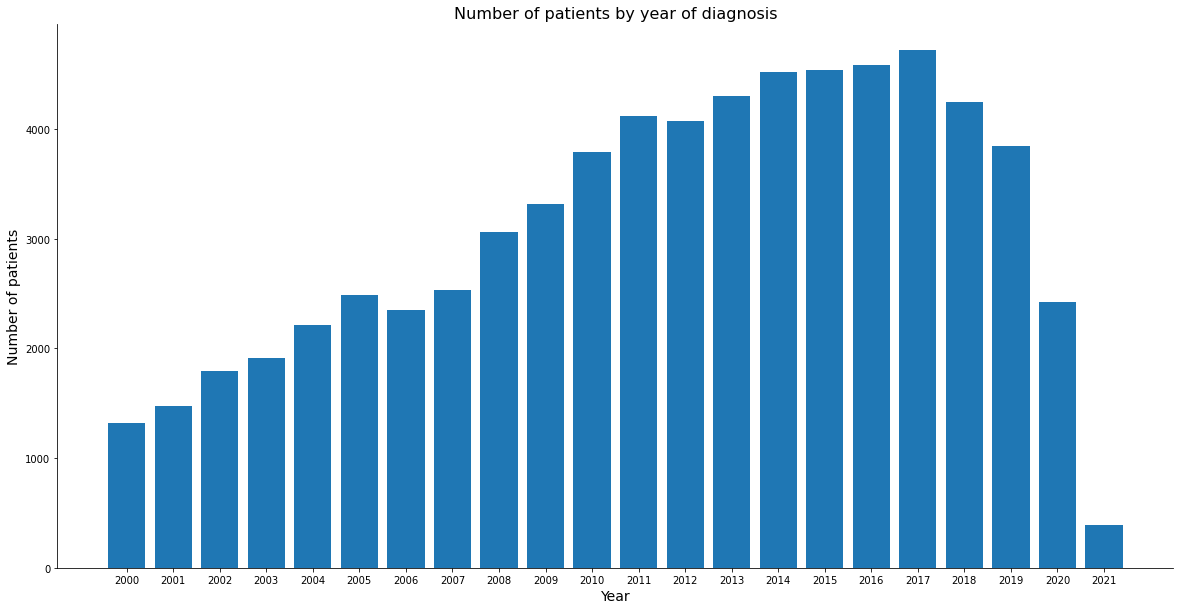

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(height = data.ANODIAG.value_counts().sort_index(), x=np.sort(data.ANODIAG.unique()))
plt.xlabel('Year', size=14)
plt.xticks(np.sort(data.ANODIAG.unique()))
plt.ylabel('Number of patients', size=14)
plt.title('Number of patients by year of diagnosis', size=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In the following graph we have the number of patients by sex, it's possible to notice that in each year the values are close for men and women.

In [ ]:
masc = data[data.SEXO == 1]
fem = data[data.SEXO == 2]

mascx = np.sort(masc.ANODIAG.unique())
mascy = masc.ANODIAG.value_counts().sort_index()

femx = np.sort(fem.ANODIAG.unique())
femy = fem.ANODIAG.value_counts().sort_index()

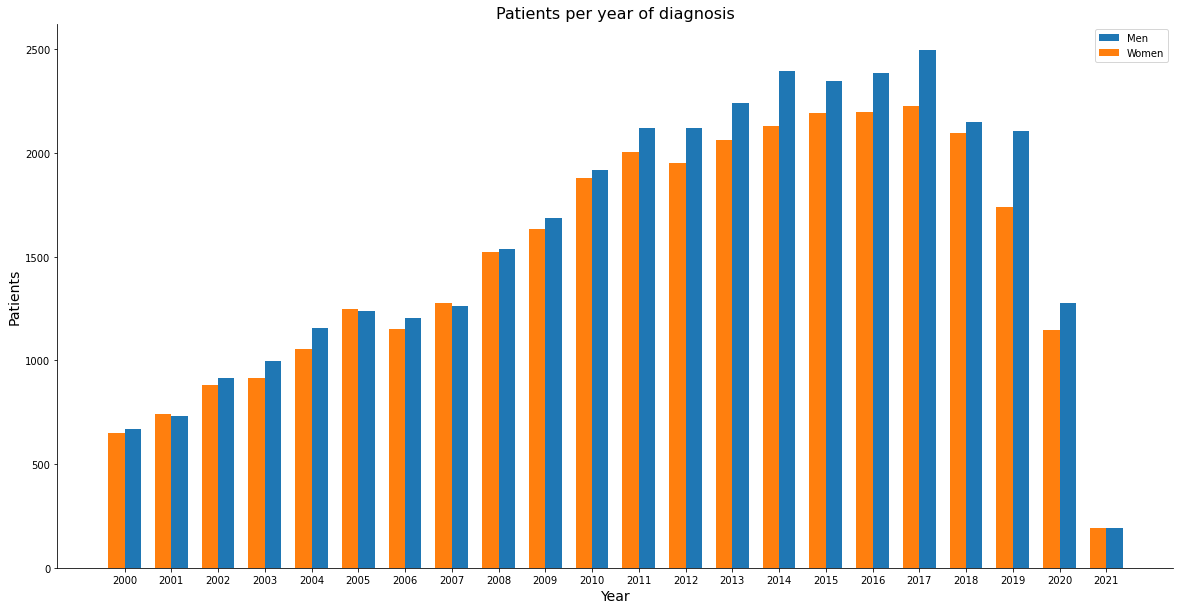

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
width = 0.35
ax1 = ax.bar(mascx + width/2, mascy, width, label='Men')
ax2 = ax.bar(femx - width/2, femy, width, label='Women')
ax.set_xlabel('Year', size=14)
ax.set_xticks(mascx)
ax.set_ylabel('Patients', size=14)
ax.set_title('Patients per year of diagnosis', size=16)

ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Analyzing the percentage of patients by age, we can see that women present the disease earlier, we have 23% of women from 30 to 49 years old against 11% of men in the same age group, but after 60 years old the number of men is higher in relation to women. It is also noticed that there is a higher incidence of cancer after 40 years old, with more than 85% of cases in both genders being in this age group.

In [ ]:
# Using the replace to change the string format for the age group column
masc.FAIXAETAR = masc.FAIXAETAR.replace(['00-09', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69'],
                                        ['00 to 09', '10 to 19', '20 to 29', '30 to 39', '40 to 49', '50 to 59', '60 to 69'])
fem.FAIXAETAR = fem.FAIXAETAR.replace(['00-09', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69'],
                                      ['00 to 09', '10 to 19', '20 to 29', '30 to 39', '40 to 49', '50 to 59', '60 to 69'])

In [ ]:
mascx = np.sort(masc.FAIXAETAR.unique())
mascy = masc.FAIXAETAR.value_counts().sort_index()

femx = np.sort(fem.FAIXAETAR.unique())
femy = fem.FAIXAETAR.value_counts().sort_index()

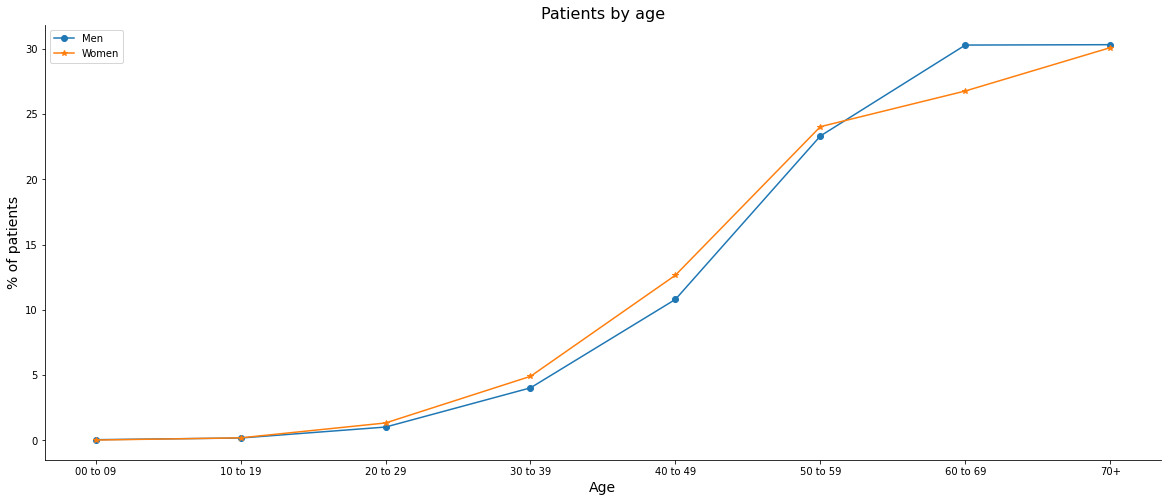

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax1 = ax.plot(mascx, (mascy/masc.shape[0])*100, label='Men', marker='o')
ax2 = ax.plot(femx, (femy/fem.shape[0])*100, label='Women', marker='*')
ax.set_xlabel('Age', size=14)
ax.set_ylabel('% of patients', size=14)
ax.set_title('Patients by age', size=16)

ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Looking at the clinical stage by sex, lower values for staging represent less aggressive diseases, we see women with more cases for stages 0, 1 and 3 and men with higher numbers in stage 2 and much higher in stage 4.

The clinical stage assists the doctors in the therapeutic planning and in the evaluation of the proposed treatment, in addition to serving for the prediction of the prognosis.

In the analysis of the data according to staging, cases reported as X (cases which it is not possible to perform staging or without information) and Y (type of cancer which the classification of malignant TNM tumors are not applied) were excluded.

In [ ]:
EC = list(np.sort(data.ECGRUP.unique()))[:5] # Categories 0, I, II, III, IV, without X and Y

mascEC = masc.loc[masc.ECGRUP.isin(EC)]
femEC = fem.loc[fem.ECGRUP.isin(EC)]

mascx = np.sort(mascEC.ECGRUP.unique())
mascy = mascEC.ECGRUP.value_counts().sort_index()

femx = np.sort(femEC.ECGRUP.unique())
femy = femEC.ECGRUP.value_counts().sort_index()

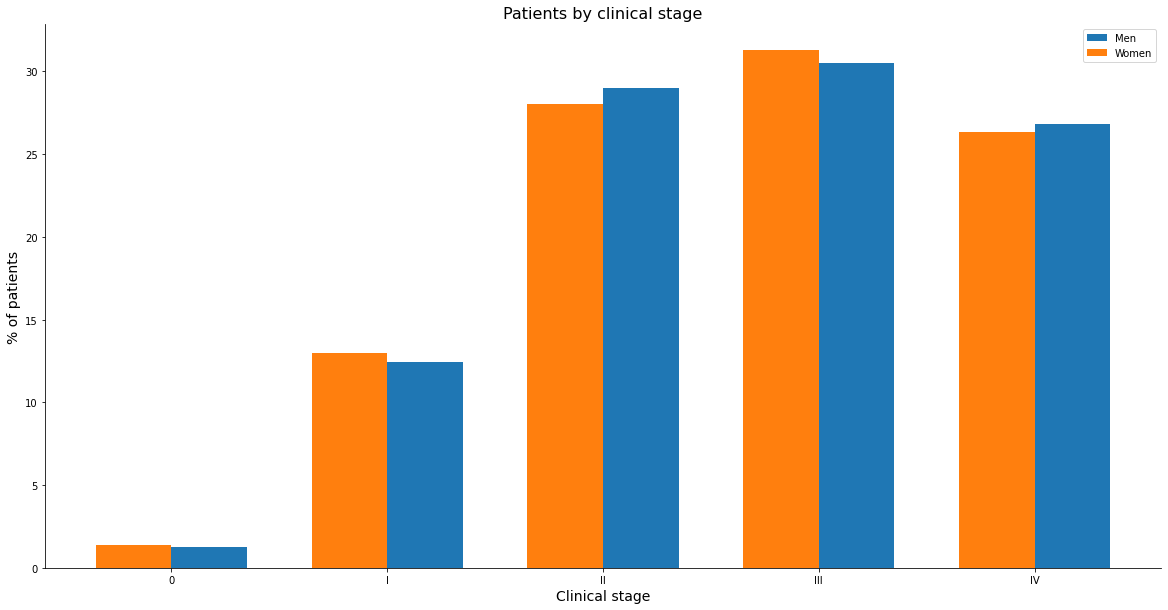

In [ ]:
x = np.arange(len(mascx))
fig, ax = plt.subplots(figsize=(20, 10))
width = 0.35
ax1 = ax.bar(x + width/2, (mascy/mascEC.shape[0])*100, width, label='Men')
ax2 = ax.bar(x - width/2, (femy/femEC.shape[0])*100, width, label='Women')
ax.set_xlabel('Clinical stage', size=14)
ax.set_ylabel('% of patients', size=14)
ax.set_title('Patients by clinical stage', size=16)

ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(list(mascx))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

To analyze the time between consultation and diagnosis, the median number of days for each year was used, looking only at patients without diagnosis and without treatment in this first graph. For 2020 and 2021 we have less data, so the median is not realiable.

In [ ]:
df_diag1 = data[data.DIAGPREV == 1] # without diagnosis/without treatment
df_diag2 = data[data.DIAGPREV == 2] # with diagnosis/without treatment

In [ ]:
x = np.sort(df_diag1.ANODIAG.unique())
y = df_diag1.groupby('ANODIAG')['CONSDIAG'].median()

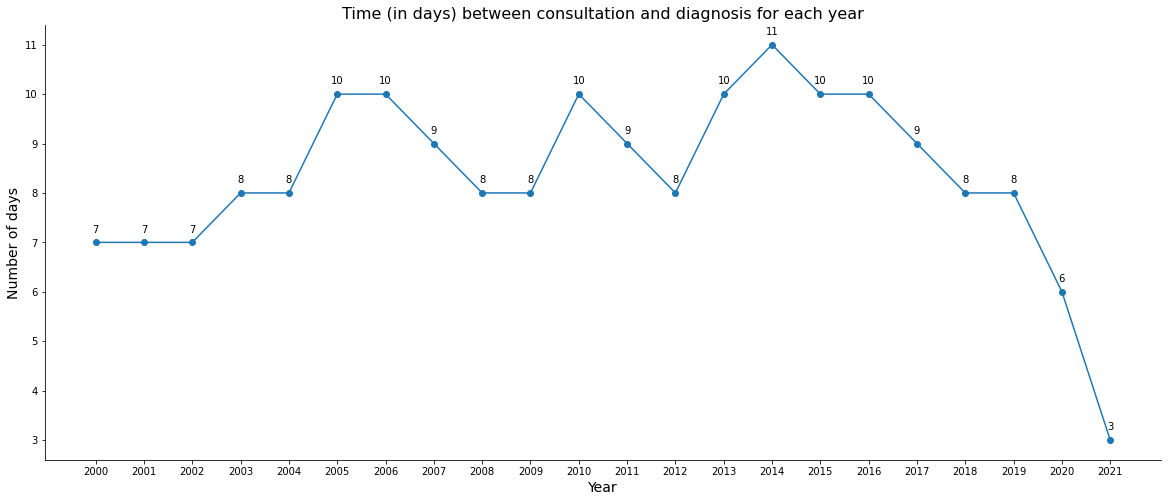

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(x, y, marker='o')
plt.xlabel('Year', size=14)
plt.xticks(x)
plt.ylabel('Number of days', size=14)
plt.title('Time (in days) between consultation and diagnosis for each year', size=16)
for xi, yi in zip(x,y):
    label = '{:.0f}'.format(yi)
    plt.annotate(label, # this is the text
                 (xi, yi), # this is the point to label
                 textcoords='offset points', # how to position the text
                 xytext=(0, 10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Now looking at the data from the latest patient information, we have a higher number of women in the category alive and of men in the two categories related to patient death, by cancer and other causes.

In [ ]:
# 1 – Alive with cancer; 2 – Alive, without other specifications;
# 3 – Death by cancer; 4 – Death by other causes, without other specifications
data['ULTINFO'].value_counts()

3.0    27923
2.0    23689
1.0     8371
4.0     8029
Name: ULTINFO, dtype: int64

In [ ]:
mascx = np.sort(masc.ULTINFO.unique())
mascy = masc.ULTINFO.value_counts().sort_index()

femx = np.sort(fem.ULTINFO.unique())
femy = fem.ULTINFO.value_counts().sort_index()

x_ticks = ['Alive with cancer', 'Alive, without other specifications', 'Death by cancer', 'Death by other causes']

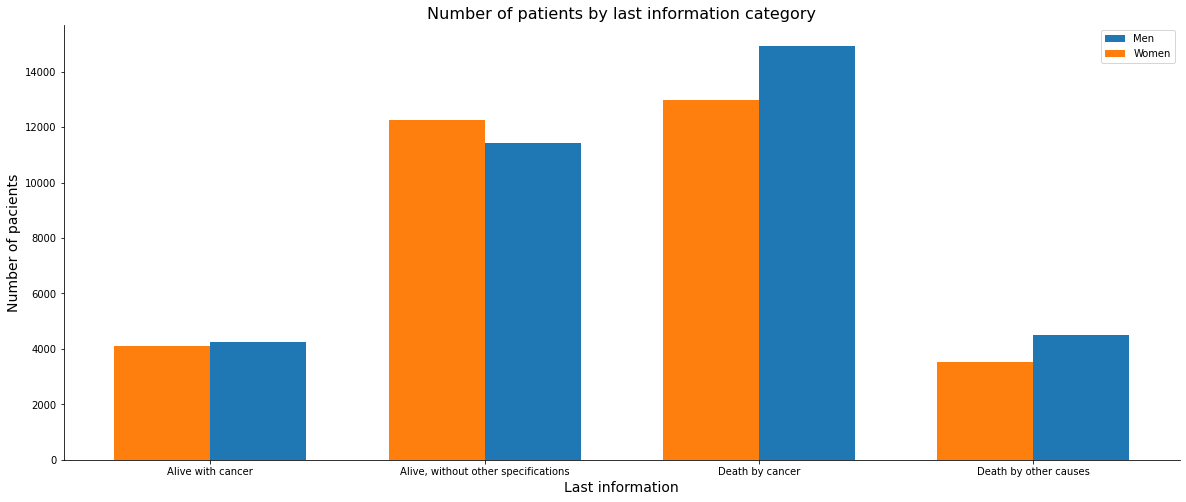

In [ ]:
x = np.arange(len(x_ticks))
fig, ax = plt.subplots(figsize=(20, 8))
width = 0.35
ax1 = ax.bar(x + width/2, mascy, width, label='Men')
ax2 = ax.bar(x - width/2, femy, width, label='Women')
ax.set_xlabel('Last information', size=14)
ax.set_ylabel('Number of pacients', size=14)
ax.set_title('Number of patients by last information category', size=16)

ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(list(x_ticks))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Now we will analyze the correlation of the `ULTINFO` column with the others in this dataset, we notice a good correlation with `ANODIAG`, which has the year of the patient's diagnosis, and with `CATEATEND`, which indicates the category of patient care at the hospital, otherwise we don't have such high correlations. 


In [ ]:
df_aux = data.copy()
df_aux.drop(columns=[#'S',
                     'META03','META04',
                     #'QUIMIOANT','HORMOANT','TMOANT','IMUNOANT','OUTROANT',
                     #'CICI','CICIGRUP','CICISUBGRU',
                     'REC04','TMOAPOS'], inplace=True)
corr_matrix = df_aux.corr()
abs(corr_matrix['ULTINFO']).sort_values(ascending = False)

ULTINFO          1.000000
ANODIAG          0.307997
CATEATEND        0.222954
IDADE            0.152825
NENHUMAPOS       0.123002
NAOTRAT          0.114400
OUTROAPOS        0.106963
NENHUM           0.104858
DIAGPREV         0.102796
CIRURGIA         0.085427
QUIMIOAPOS       0.079463
RECREGIO         0.074847
RECNENHUM        0.067192
RECLOCAL         0.052129
ESCOLARI         0.047074
SEXO             0.043748
QUIMIO           0.043335
DIAGTRAT         0.041150
RRAS             0.035150
RADIOAPOS        0.034604
CONSDIAG         0.034106
CIRURAPOS        0.032537
comportamento    0.031074
RADIO            0.027211
OUTROS           0.015453
IBGEATEN         0.014499
HORMONIO         0.009892
HORMOAPOS        0.007904
NENHUMANT        0.007884
TRATCONS         0.007383
IMUNOAPOS        0.007345
IBGE             0.006388
MORFO            0.004807
RECDIST          0.003953
TMO              0.001884
IMUNO            0.000166
Name: ULTINFO, dtype: float64

In the correlation matrix we can see the correlations between all columns and as described above for the case of the analysis only for `ULTINFO`, we do not have very high correlations. 

It is important to note that the data has not been processed yet, so after preprocessing a more explanatory matrix for the data can be obtained.

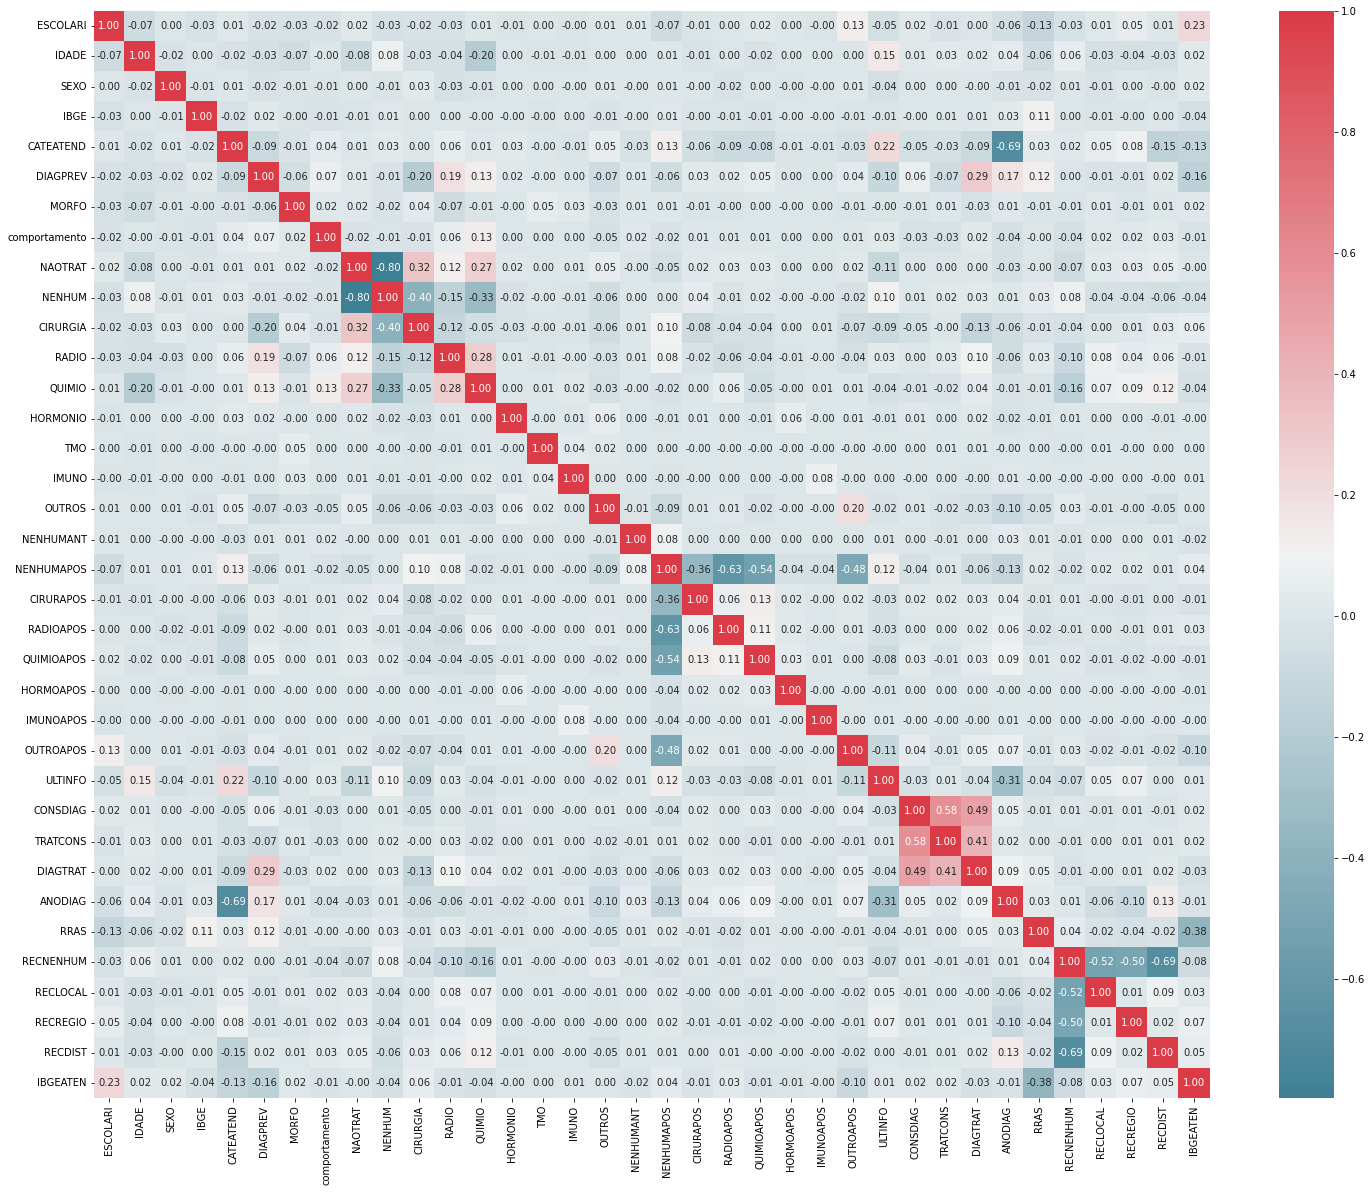

In [ ]:
fig, ax = plt.subplots(figsize = (25, 20))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
 
sns.heatmap(corr_matrix, cmap = colormap, annot = True, fmt = '.2f')
fig.show()

With the histograms you can see how the distributions of the dataset columns are, but since we have most of them with categorical data, the histograms bring information about the amount of data in the respective categories.

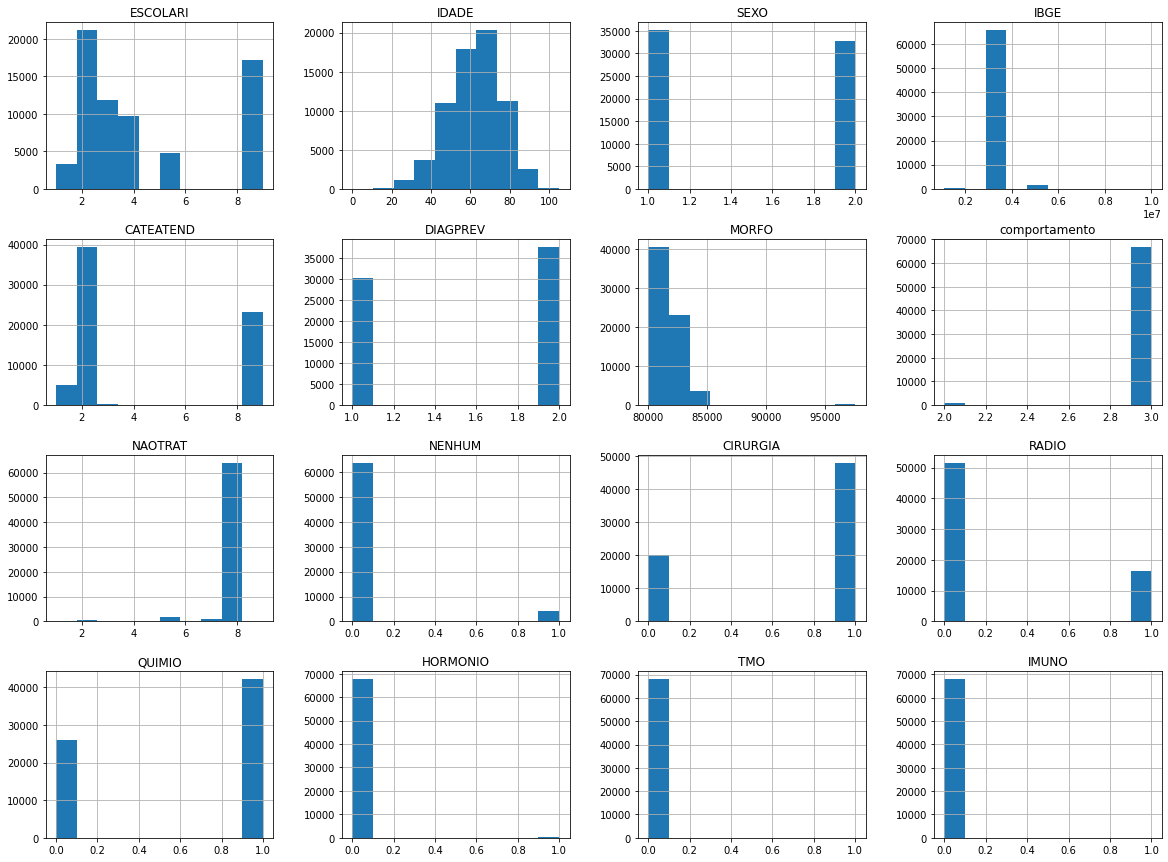

In [ ]:
data.iloc[:,:38].hist(bins=10, figsize=(20, 15))
plt.show()

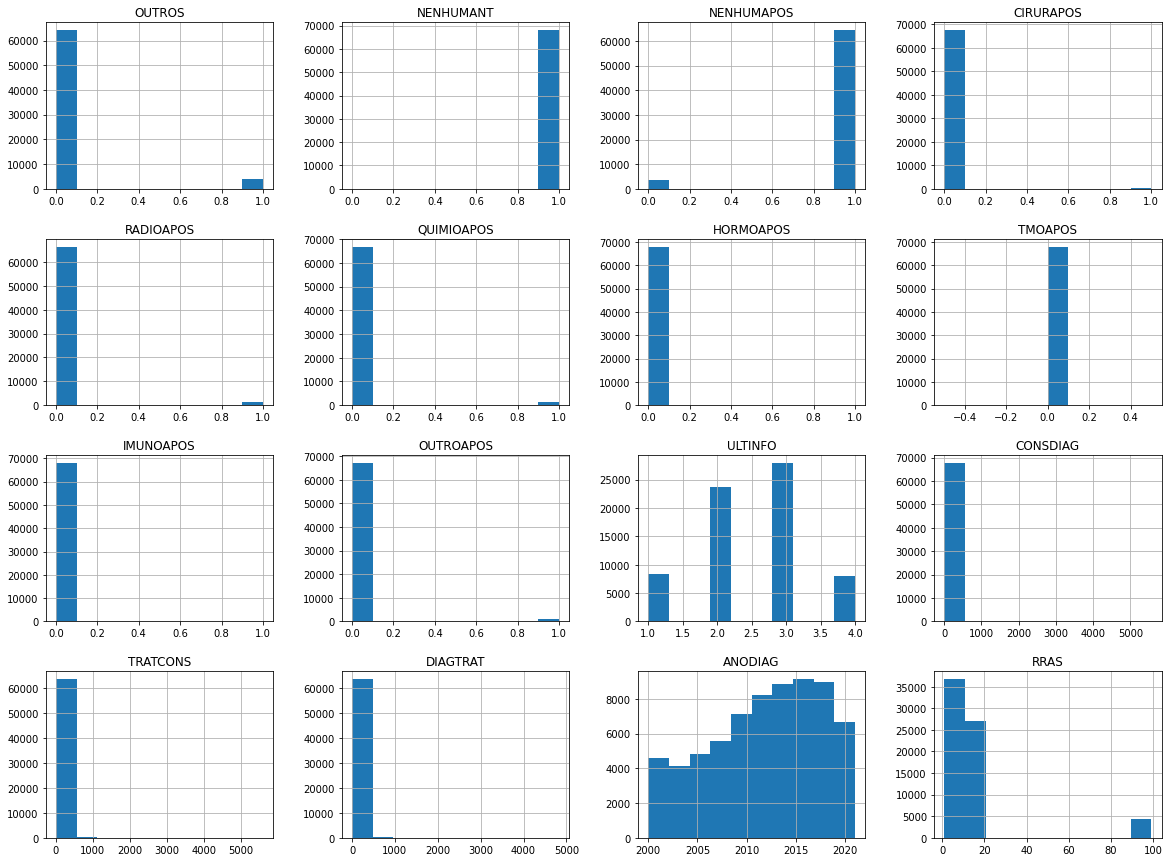

In [ ]:
data.iloc[:,38:58].hist(bins=10, figsize=(20, 15))
plt.show()

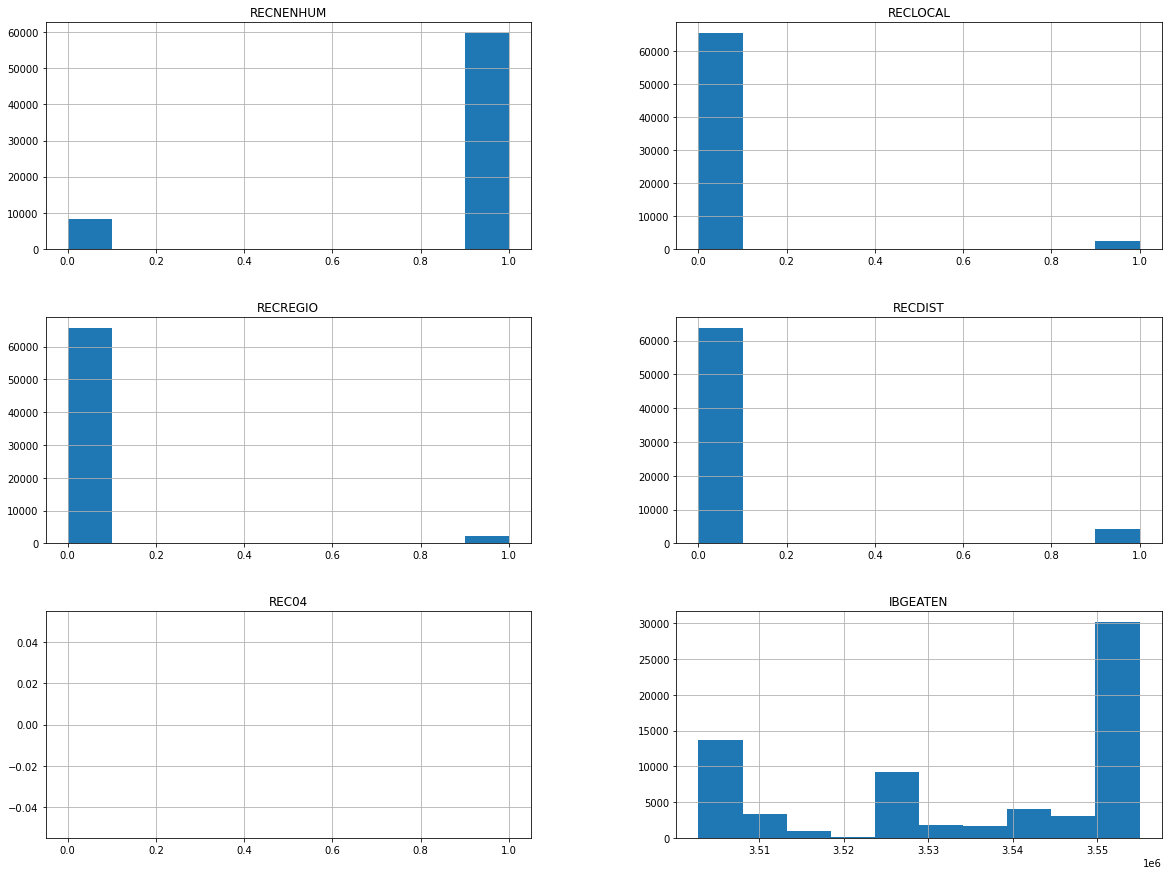

In [ ]:
data.iloc[:, 58:].hist(bins=10, figsize=(20, 15))
plt.show()

## **Missing values**

Now let's see the amount of missing values per column, we have 17 columns with more than 50% of missing data, being 6 with all missing values, if we want to use any of these for the machine learning models, it will be necessary to treat the missing values, placing 0 or some string that indicates that the value is missing, for example. 

Another option is not using the columns in the analysis, we will see later in this project the proposed solutions to solve this problem.

In [ ]:
missing = data.isna().sum().sort_values(ascending=False)
prop = missing[missing > 0]/data.shape[0]
prop

REC04       1.000000
META04      0.994428
REC03       0.989811
META03      0.977754
REC02       0.963551
META02      0.920148
REC01       0.873407
META01      0.748695
DRS         0.062488
TRATCONS    0.061179
DIAGTRAT    0.061179
ULTINFO     0.000015
dtype: float64

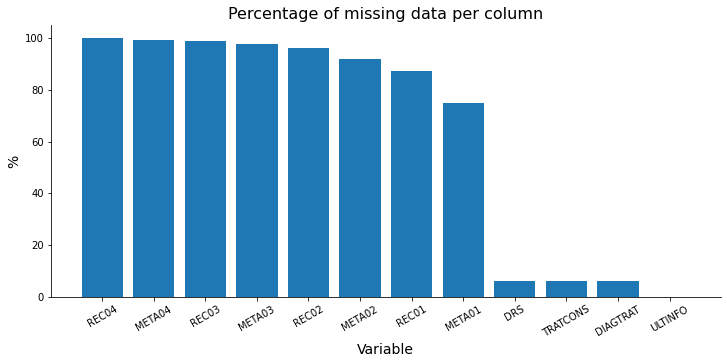

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(height = prop*100, x=prop.index)
plt.xlabel('Variable', size=14)
plt.ylabel('%', size=14)
plt.title('Percentage of missing data per column', size=16)
plt.xticks(rotation=30)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
# REC04 - Local da recidiva/metástase. Formato: C99
data[data['REC04'].isna() == False]['REC04'].shape

(0,)

In [ ]:
# META04 - Metástase. Formato: C99
data[data['META04'].isna() == False]['META04'].shape

(379,)

In [ ]:
# REC03 - Local da recidiva/metástase. Formato: C99
data[data['REC03'].isna() == False]['REC03'].shape

(693,)

In [ ]:
# META03 - Metástase. Formato: C99
data[data['META03'].isna() == False]['META03'].shape

(1513,)

In [ ]:
# REC02 - Local da recidiva/metástase. Formato: C99
data[data['REC02'].isna() == False]['REC02'].shape

(2479,)

In [ ]:
# META02 - Metástase. Formato: C99
data[data['META02'].isna() == False]['META02'].shape

(5431,)

In [ ]:
# REC01 - Local da recidiva/metástase. Formato: C99
data[data['REC01'].isna() == False]['REC01'].shape

(8610,)

In [ ]:
# META01 - Metástase. Formato: C99
data[data['META01'].isna() == False]['META01'].shape

(17092,)

In [ ]:
# DRS - DRS 
data[data['DRS'].isna() == False]['DRS'].shape

(63763,)

In [ ]:
# TRATCONS - Diferença em dias entre as datas de consulta e tratamento
data[data['TRATCONS'].isna() == False]['TRATCONS'].shape

(63852,)

In [ ]:
# DIAGTRAT - Diferença em dias entre as datas de tratamento e diagnóstico
data[data['DIAGTRAT'].isna() == False]['DIAGTRAT'].shape

(63852,)

In [ ]:
# ULTINFO - Última informação do paciente
data[data['ULTINFO'].isna() == False]['ULTINFO'].shape 

(68012,)

## **Columns analysis**

In this section, the columns will be analyzed individually, with the aim of examining each one of them and obtaining a function that will be used in the data before starting the study with the machine learning models.

The columns were divided according to the type of each one, resulting in the categories: dates, numeric categories, letters categories, numbers, strings, letters and numbers categories.

Columns with unique values will be dropped from the dataset in the function called `variables_preprocessing`. Another treatment that will be done in the columns is the filling of string columns with missing values with ** Sem informação **, being the columns:

* `META01`;

* `META02`;

* `META03`;

* `META04`;

* `REC01`;

* `REC02`;

* `REC03`.

The `DRS` column will have the missing values filled with 0, after using the split method to obtain only the numbers in this column.

We also excluded from the data `ECGRUP` with X and Y values and only selected morphologies 81403 and `comportamento` 3.

From the column `UFRESID` will be selected the data for SP state. Finally, the columns that were dropped from the dataset, because they have unique values, only NaN values or because they are descriptions of the disease, are the following:

* `UFNASC`;

* `CIDADE`;

* `DESCTOPO`;

* `DESCMORFO`;

* `REC04`.

> Check the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models) to see the complete function.

In [ ]:
df_aux = read_csv(path, drop_id=True)

(68013, 68)


### **Dates**

In [ ]:
# #NULL! to NaN
df_aux.loc[df_aux.DTRECIDIVA == '#NULL!', 'DTRECIDIVA'] = np.nan
df_aux.loc[df_aux.DTULTINFO == '#NULL!', 'DTULTINFO'] = np.nan
df_aux.loc[df_aux.DTTRAT == '#NULL!', 'DTTRAT'] = np.nan

*   **DTCONSULT**: Data da 1ª consulta (date = 10). Formato: DD/MM/YYYY	
*   **DTDIAG**: Data do diagnóstico (date = 10). Formato: DD/MM/YYYY
*   **DTTRAT**: Data de inicio do tratamento (date = 10). Formato: DD/MM/YYYY	
*   **DTULTINFO**: Data da última informação do paciente (date = 10). Formato: DD/MM/YYYY
*   **DTRECIDIVA**: Data da última ocorrência de recidiva (date = 10). Formato: DD/MM/YYYY

In [ ]:
# Data - DTCONSULT, DTDIAG, DTTRAT, DTULTINFO, DTRECIDIVA
dates = ['DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTULTINFO', 'DTRECIDIVA']
df_aux[dates].isna().sum()

DTCONSULT         0
DTDIAG            0
DTTRAT         4161
DTULTINFO         5
DTRECIDIVA    57470
dtype: int64

In [ ]:
(df_aux[dates].isna().sum()/df_aux.shape[0])*100

DTCONSULT      0.000000
DTDIAG         0.000000
DTTRAT         6.117948
DTULTINFO      0.007352
DTRECIDIVA    84.498552
dtype: float64

In [ ]:
df_aux[dates].head(3)

,DTCONSULT,DTDIAG,DTTRAT,DTULTINFO,DTRECIDIVA
0,2000-01-05,2000-01-13,2000-01-13 00:00:00,2006-12-13 00:00:00,NaN
1,2001-06-08,2001-06-08,2001-07-30 00:00:00,2005-01-26 00:00:00,2004-10-26 00:00:00
2,2002-02-04,2002-02-04,2002-04-26 00:00:00,2003-06-08 00:00:00,NaN


### **Numerical categories**

*   **SEXO**: Sexo do paciente (int = 1). 

      1 – MASCULINO

      2 – FEMININO

In [ ]:
df_aux.SEXO.value_counts()

1    35136
2    32877
Name: SEXO, dtype: int64

*   **ESCOLARI**: Código para escolaridade do paciente (int = 1).

      1 – ANALFABETO

      2 – ENS. FUND. INCOMPLETO

      3 – ENS. FUND. COMPLETO

      4 – ENSINO MÉDIO

      5 – SUPERIOR

      9 – IGNORADA

In [ ]:
df_aux.ESCOLARI.value_counts()

2    21117
9    17133
3    11862
4     9748
5     4835
1     3318
Name: ESCOLARI, dtype: int64

*   **CATEATEND**: Categoria de atendimento ao diagnóstico (int = 1). 

      1 - CONVENIO

      2 - SUS

      3 – PARTICULAR

      9 – SEM INFORMAÇÃO

In [ ]:
df_aux.CATEATEND.value_counts()

2    39473
9    23273
1     5025
3      242
Name: CATEATEND, dtype: int64

*   **DIAGPREV**: Diagnóstico e tratamento anterior (int = 1).

      1 – SEM DIAGNÓSTICO / SEM TRATAMENTO
      
      2 – COM DIAGNÓSTICO / SEM TRATAMENTO

In [ ]:
df_aux.DIAGPREV.value_counts()

2    37683
1    30330
Name: DIAGPREV, dtype: int64

*   **NAOTRAT**: Código da razão para não realização do tratamento (int = 1).
      
      1 – RECUSA DO TRATAMENTO
      
      2 – DOENÇA AVANÇADA, FALTA DE CONDIÇÕES CLINICAS
      
      3 – OUTRAS DOENÇAS ASSOCIADAS
      
      4 – ABANDONO DE TRATAMENTO
      
      5 – OBITO POR CANCER
      
      6 – OBITO POR OUTRAS CAUSAS, SOE
      
      7 – OUTRAS
      
      8 – NÃO SE APLICA (CASO TENHA TRATAMENTO)
      
      9 – SEM INFORMAÇÃO

In [ ]:
df_aux.NAOTRAT.value_counts()

8    63839
5     1830
7      879
2      749
9      289
6      128
3      121
1      111
4       67
Name: NAOTRAT, dtype: int64

*   **NENHUM**: Tratamento recebido no hospital = nenhum (int = 1). 0 – NÃO; 1 – SIM
*   **CIRURGIA**: Tratamento recebido no hospital = cirurgia (int = 1). 0 – NÃO; 1 – SIM
*   **RADIO**: Tratamento recebido no hospital = radioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **QUIMIO**: Tratamento recebido no hospital = quimioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **HORMONIO**: Tratamento recebido no hospital = hormonioterapia (int = 1). 0 – NÃO; 1 – SIM
*   **TMO**: Tratamento recebido no hospital = tmo (int = 1). 0 – NÃO; 1 – SIM
*   **IMUNO**: Tratamento recebido no hospital = imunoterapia (int = 1). 0 – NÃO; 1 – SIM
*   **OUTROS**: Tratamento recebido no hospital = outros (int = 1). 0 – NÃO; 1 – SIM

In [ ]:
df_aux.NENHUM.unique()

array([0, 1])

In [ ]:
df_aux.CIRURGIA.unique()

array([1, 0])

In [ ]:
df_aux.RADIO.unique()

array([1, 0])

In [ ]:
df_aux.QUIMIO.unique()

array([1, 0])

In [ ]:
df_aux.HORMONIO.unique()

array([0, 1])

In [ ]:
df_aux.TMO.unique()

array([0, 1])

In [ ]:
df_aux.IMUNO.unique()

array([0, 1])

In [ ]:
df_aux.OUTROS.unique()

array([1, 0])

*   **NENHUMANT**: Tratamento recebido fora do hospital e antes da admissão = nenhum (int = 1). 0 – NÃO; 1 – SIM

In [ ]:
df_aux.NENHUMANT.unique()

array([1, 0])

*   **NENHUMAPOS**: Tratamento recebido fora do hospital e durante/após admissão = nenhum	(int = 1). 0 – NÃO; 1 – SIM	
*   **CIRURAPOS**: Tratamento recebido fora do hospital e durante/após admissão = cirurgia	(int = 1). 0 – NÃO; 1 – SIM	
*   **RADIOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = radioterapia	(int = 1). 0 – NÃO; 1 – SIM	
*   **QUIMIOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = quimioterapia	(int = 1). 0 – NÃO; 1 – SIM		
*   **HORMOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = hormonioterapia	(int = 1). 0 – NÃO; 1 – SIM		
*   **TMOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = tmo	(int = 1). 0 – NÃO; 1 – SIM		
*   **IMUNOAPOS**: Tratamento recebido fora do hospital e durante/após admissão = imunoterapia	(int = 1). 0 – NÃO; 1 – SIM	
*   **OUTROAPOS**: Tratamento recebido fora do hospital e durante/após admissão = outros	(int = 1). 0 – NÃO; 1 – SIM	

In [ ]:
df_aux.NENHUMAPOS.unique()

array([1, 0])

In [ ]:
df_aux.CIRURAPOS.unique()

array([0, 1])

In [ ]:
df_aux.RADIOAPOS.unique()

array([0, 1])

In [ ]:
df_aux.QUIMIOAPOS.unique()

array([0, 1])

In [ ]:
df_aux.HORMOAPOS.unique()

array([0, 1])

In [ ]:
df_aux.TMOAPOS.unique() ### drop

array([0])

In [ ]:
df_aux.IMUNOAPOS.unique()

array([0, 1])

In [ ]:
df_aux.OUTROAPOS.unique()

array([0, 1])

*   **ULTINFO**: Última informação sobre o paciente (int = 1).
      
      1 – VIVO, COM CÂNCER
      
      2 – VIVO, SOE
      
      3 – OBITO POR CANCER
      
      4 – OBITO POR OUTRAS CAUSAS, SOE

In [ ]:
df_aux.ULTINFO.value_counts()

3.0    27923
2.0    23689
1.0     8371
4.0     8029
Name: ULTINFO, dtype: int64

*   **RECNENHUM**: Sem recidiva (int = 1). 0 - Não; 1 - Sim
*   **RECLOCAL**: Recidiva local (int = 1). 0 - Não; 1 - Sim	
*   **RECREGIO**: Recidiva regional (int = 1). 0 - Não; 1 - Sim	
*   **RECDIST**: Recidiva a distância / metástase (int = 1). 0 - Não; 1 - Sim

In [ ]:
df_aux.RECNENHUM.value_counts()

1    59744
0     8269
Name: RECNENHUM, dtype: int64

In [ ]:
df_aux.RECLOCAL.value_counts()

0    65555
1     2458
Name: RECLOCAL, dtype: int64

In [ ]:
df_aux.RECREGIO.value_counts()

0    65757
1     2256
Name: RECREGIO, dtype: int64

In [ ]:
df_aux.RECDIST.value_counts()

0    63810
1     4203
Name: RECDIST, dtype: int64

### **Letter categories**

*   **TRATAMENTO**: Código de combinação dos tratamentos realizados (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento
      
      J – Nenhum tratamento realizado	
*   **TRATHOSP**: Código de combinação dos tratamentos realizados no hospital (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento

      J – Nenhum tratamento realizado
*   **TRATFAPOS**: Código de combinação dos tratamentos realizados após admissão fora do hospital (char = 1).
      
      A – Cirurgia
      
      B – Radioterapia
      
      C – Quimioterapia
      
      D – Cirurgia + Radioterapia
      
      E – Cirurgia + Quimioterapia
      
      F – Radioterapia + Quimioterapia
      
      G – Cirurgia + Radio + Quimio
      
      H – Cirurgia + Radio + Quimio + Hormonio
      
      I – Outras combinações de tratamento
      
      J – Nenhum tratamento realizado
      
      K – Sem informação

In [ ]:
np.sort(df_aux.TRATAMENTO.unique())

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object)

In [ ]:
np.sort(df_aux.TRATHOSP.unique())

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object)

In [ ]:
np.sort(df_aux.TRATFAPOS.unique())

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'J'], dtype=object)

### **Numbers**

*   **IDADE**: Idade do paciente (int = 3).


In [ ]:
df_aux.IDADE.nunique()

103

*   **CONSDIAG**: Diferença em dias entre as datas de consulta o diagnóstico (num = dias).
*   **TRATCONS**: Diferença em dias entre as datas de consulta e tratamento (num = dias).	
*   **DIAGTRAT**: Diferença em dias entre as datas de tratamento e diagnóstico (num = dias).


In [ ]:
df_aux.CONSDIAG.isna().sum()

0

In [ ]:
df_aux.TRATCONS.isna().sum()

4161

In [ ]:
df_aux.DIAGTRAT.isna().sum()

4161

*   **ANODIAG**: Ano de diagnóstico (int = 4). Formato: 9999


In [ ]:
np.sort(df_aux.ANODIAG.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

*   **IBGE**: Código da cidade de residência do paciente segundo IBGE com digito verificador (int = 7).

In [ ]:
df_aux.IBGE.nunique()

1361

* **IBGEATEN**

In [ ]:
df_aux.IBGEATEN.isna().sum()

0

*   **MORFO**: Código da morfologia (char = 5). Formato: 99999


In [ ]:
df_aux.MORFO.unique()

array([81403, 82113, 84803, 80103, 84813, 82493, 80323, 82403, 84903,
       82632, 82633, 82102, 81402, 82463, 85603, 81473, 82203, 82443,
       82453, 82433, 90703, 89003, 88103, 96873, 95913, 95903, 96553,
       96803, 96903, 96503, 80003, 82623, 80203, 80102, 82553, 82103,
       82603, 84303, 80703, 81482, 80413, 83103, 97023, 82612, 82613,
       85743, 89363, 85103, 88903, 80043, 91203, 82153, 96843, 80133,
       88003, 81233, 84403, 82303, 80833, 96733, 97283, 82213, 85503,
       82013, 83233, 88503, 81903, 81243, 87203, 85723, 81433, 82513,
       97143, 84703, 81203, 85763, 80213, 96983, 80763, 96993, 80702,
       96703, 88043, 89333, 89803, 80503, 85703, 88583, 88513, 84603,
       88013, 88023, 84413, 80123, 81413, 80513, 80523, 95713, 82413,
       95953, 80843, 84823, 80023, 80333, 80723, 96833, 81303, 95963,
       97583, 82313, 80713, 88303, 80303, 96753, 88533, 80733, 96523,
       89013, 80113, 87463, 88053, 84713, 91403, 80153, 89353, 88523,
       88913, 80753,

*   **RRAS**: RRAS (int = 200). [1,2,3, ... ,16,17,99]

In [ ]:
np.sort(df_aux.RRAS.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       99])

In [ ]:
df_aux.RRAS.value_counts()

6     17026
13     7279
12     6948
9      4751
15     4272
99     4250
10     3285
1      2874
14     2731
8      2536
17     2422
16     2028
2      1775
7      1771
5      1479
11     1362
4       899
3       325
Name: RRAS, dtype: int64

* **comportamento**

In [ ]:
df_aux.comportamento.unique()

array([3, 2])

### **Strings**

*   **UFNASC**: UF de nascimento (char = 2). Outras opções: SI - Sem informação; OP - Outro país.	
*   **UFRESID**: UF de residência (char = 2). Outras opções: OP - Outro país.
*   **CIDADE**: Cidade de residência do paciente (char = 200).

In [ ]:
df_aux.UFNASC.unique()

array(['SP', 'MG', 'BA', 'PR', 'SI', 'MA', 'SE', 'MT', 'GO', 'PA', 'AM',
       'MS', 'RO', 'CE', 'PI', 'AL', 'OP', 'PE', 'ES', 'RJ', 'SC', 'PB',
       'RS', 'RN', 'DF', 'AC', 'RR', 'TO', 'AP'], dtype=object)

In [ ]:
df_aux.UFRESID.unique()

array(['MG', 'SP', 'MT', 'PA', 'RO', 'ES', 'MS', 'PE', 'PR', 'GO', 'BA',
       'SE', 'TO', 'CE', 'RJ', 'PB', 'SC', 'AM', 'MA', 'DF', 'AP', 'AL',
       'PI', 'AC', 'RS', 'RR', 'RN', 'OP'], dtype=object)

In [ ]:
df_aux.CIDADE.value_counts().head(10)

SAO PAULO                17026
RIBEIRAO PRETO            1452
CAMPINAS                  1382
SAO JOSE DO RIO PRETO     1295
PIRACICABA                1002
JUNDIAI                    943
SAO BERNARDO DO CAMPO      932
MARILIA                    809
GUARULHOS                  787
OSASCO                     749
Name: CIDADE, dtype: int64

*   **FAIXAETAR**: Faixa etária do paciente (char = 5).

      00-09 

      10-19

      20-29

      30-39

      40-49

      50-59

      60-69

      70+

In [ ]:
df_aux.FAIXAETAR.unique()

array(['10-19', '00-09', '70+', '60-69', '50-59', '40-49', '30-39',
       '20-29'], dtype=object)

*   **DRS**: Departamentos Regionais de Saúde (char = 200).
      
      DRS 01  SĂO PAULO
      
      DRS 15  SĂO JOSÉ DO RIO PRETO
      
      DRS 06  BAURU
      
      DRS 07  CAMPINAS
      
      DRS 09  MARÍLIA
      
      DRS 13  RIBEIRĂO PRETO
      
      DRS 10  PIRACICABA
      
      DRS 17  TAUBATÉ
      
      DRS 16  SOROCABA
      
      DRS 05  BARRETOS
      
      DRS 03  ARARAQUARA
      
      DRS 02  ARAÇATUBA
      
      DRS 04  SANTOS
      
      DRS 14  SĂO JOĂO DA BOA VISTA
      
      DRS 08  FRANCA
      
      DRS 11  PRESIDENTE PRUDENTE
      
      DRS 12  REGISTRO

In [ ]:
df_aux.DRS.unique()

array([nan, 'DRS 10  PIRACICABA', 'DRS 01  SÃO PAULO', 'DRS 07  CAMPINAS',
       'DRS 08  FRANCA', 'DRS 03  ARARAQUARA', 'DRS 06  BAURU',
       'DRS 15  SÃO JOSÉ DO RIO PRETO', 'DRS 04  SANTOS',
       'DRS 09  MARÍLIA', 'DRS 11  PRESIDENTE PRUDENTE',
       'DRS 16  SOROCABA', 'DRS 02  ARAÇATUBA', 'DRS 13  RIBEIRÃO PRETO',
       'DRS 05  BARRETOS', 'DRS 17  TAUBATÉ',
       'DRS 14  SÃO JOÃO DA BOA VISTA', 'DRS 12  REGISTRO'], dtype=object)

In [ ]:
df_aux.DRS.isna().sum()

4250

*   **DESCTOPO**: Descrição da Topografia (char = 80).
*   **DESCMORFO**: Descrição da morfologia (char = 80).

In [ ]:
df_aux.DESCTOPO.value_counts().head(10)

RETO SOE                     28308
COLON SIGMOIDE               10445
COLON SOE                     8364
COLON ASCENDENTE              5921
JUNCAO RETOSSIGMOIDIANA       4657
COLON DESCENDENTE             3011
COLON TRANSVERSO              2574
CECO                          2479
COLON ANGULO HEPATICO DO       716
COLON ANGULO ESPLENICO DO      563
Name: DESCTOPO, dtype: int64

In [ ]:
df_aux.DESCMORFO.value_counts().head(10)

ADENOCARCINOMA SOE                        38560
ADENOCARCINOMA TUBULAR                    19706
ADENOCARCINOMA MUCINOSO                    2569
ADENOCARCINOMA EM ADENOMA TUBULOVILOSO     1120
ADENOCARCINOMA VILOSO                       642
CARCINOMA SOE                               512
CARCINOMA DE CELULAS EM ANEL DE SINETE      499
ADENOCARCINOMA PRODUTOR DE MUCINA           472
ADENOCARCINOMA IN SITU SOE                  447
CARCINOMA NEUROENDOCRINO SOE                379
Name: DESCMORFO, dtype: int64

* **HABILIT**

In [ ]:
df_aux.HABILIT.value_counts()

CACON     41391
UNACON    26622
Name: HABILIT, dtype: int64

### **Numbers and letters categories** 

*   **TOPO**: Código da topografia (char = 4). Formato: C999 	
*   **TOPOGRUP**: Grupo da topografia	(char = 3). Formato: C99

In [ ]:
df_aux.TOPO.nunique()

12

In [ ]:
df_aux.TOPOGRUP.unique()

array(['C18', 'C20', 'C19'], dtype=object)

*   **META01**: Metástase (char = 3).	Formato: C99
*   **META02**: Metástase (char = 3).	Formato: C99
*   **META03**: Metástase (char = 3).	Formato: C99
*   **META04**: Metástase (char = 3).	Formato: C99

In [ ]:
print(df_aux.META01.isna().sum())
print(df_aux.META02.isna().sum())
print(df_aux.META03.isna().sum())
print(df_aux.META04.isna().sum())

50921
62582
66500
67634


*   **REC01**: Local da recidiva/metástase (char = 3). Formato: C99 
*   **REC02**: Local da recidiva/metástase (char = 3). Formato: C99 	
*   **REC03**: Local da recidiva/metástase (char = 3). Formato: C99 
*   **REC04**: Local da recidiva/metástase (char = 3). Formato: C99

In [ ]:
print(df_aux.REC01.isna().sum())
print(df_aux.REC02.isna().sum())
print(df_aux.REC03.isna().sum())
print(df_aux.REC04.isna().sum())

59403
65534
67320
68013


*   **EC**: Estadio clínico (char = 5). [0,IIIB,IA, ...]
*   **ECGRUP**: Grupo do estadiamento clínico (char = 3). [0,I,II,III,IV,Y,X]

In [ ]:
np.sort(df_aux.EC.unique())

array(['0', 'I', 'II', 'IIA', 'IIB', 'IIC', 'III', 'IIIA', 'IIIB', 'IIIC',
       'IV', 'IVA', 'IVB', 'IVC', 'X', 'Y'], dtype=object)

In [ ]:
np.sort(df_aux.ECGRUP.unique())

array(['0', 'I', 'II', 'III', 'IV', 'X', 'Y'], dtype=object)

In [ ]:
df_aux.ECGRUP.value_counts()

III    19576
II     18092
IV     16842
I       8055
X       3639
Y        973
0        836
Name: ECGRUP, dtype: int64

*   **T**: Classificação TNM - T (char = 5).
*   **N**: Classificação TNM - N (char = 5).
*   **M**: Classificação TNM - M (char = 3).
	


In [ ]:
np.sort(df_aux['T'].unique())

array(['0', '1', '1A', '1B', '2', '3', '4', '4A', '4B', 'IS', 'X', 'Y'],
      dtype=object)

In [ ]:
np.sort(df_aux['N'].unique())

array(['0', '1', '1A', '1B', '1C', '2', '2A', '2B', 'X', 'Y'],
      dtype=object)

In [ ]:
np.sort(df_aux['M'].unique())

array(['0', '1', '1A', '1B', 'X', 'Y'], dtype=object)

### **First preprocessing**

Here the `variables_preprocessing` function will be applied, obtaining a new dataset with 75 columns (the raw data has 93 columns). It appears that we still have columns with missing values (`DTRECIDIVA`, `TRATCONS`, `DTTRAT`, `DIAGTRAT`, `REGISTRADO` and `ULTINFO`), all will be dealt with later. 

After the function, the new dataset will be saved as a csv file, to be used in the sequence.

In [ ]:
df = variables_preprocessing(df_aux)
df.head(3)

,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DTCONSULT,DIAGPREV,DTDIAG,EC,ECGRUP,DTTRAT,TRATHOSP,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,FAIXAETAR,DRS,RRAS,DTRECIDIVA,RECNENHUM,IBGEATEN
4,4,19,2,3538709,9,2004-06-22,2,2004-06-22,IV,IV,2004-07-26 00:00:00,I,0,0,1,1,0,0,0,1,1,2018-02-14 00:00:00,2.0,0,34.0,34.0,2004,10-19,10,14,NaN,1,3538709
6,9,19,1,3537107,2,2006-12-20,2,2006-10-17,IIIA,III,2006-12-26 00:00:00,I,0,0,0,1,0,0,0,1,1,2014-04-22 00:00:00,3.0,64,6.0,70.0,2006,10-19,07,15,NaN,1,3509502
7,4,19,1,3516200,9,2007-10-05,2,2007-09-26,IIB,II,2007-10-11 00:00:00,F,0,0,1,1,0,0,0,0,1,2020-09-11 00:00:00,2.0,9,6.0,15.0,2007,10-19,08,13,NaN,1,3516200


In [ ]:
df.shape

(33565, 33)

In [ ]:
df.isna().sum().sort_values(ascending=False).head(8)

DTRECIDIVA    28500
DTTRAT         1644
DIAGTRAT       1644
TRATCONS       1644
DTULTINFO         5
ULTINFO           1
IBGEATEN          0
DIAGPREV          0
dtype: int64

In [ ]:
save_csv(df, '/content/drive/MyDrive/Trabalho/Cancer/Datasets/colorretal_first_pp.csv')

CSV file saved successfully!


# **Creating new columns**

In this section, new columns will be created based on the difference between the date columns, the last information column and the recurrence column.

We will use one dataset, with `UFRESID` for São Paulo state, created in the previous section.

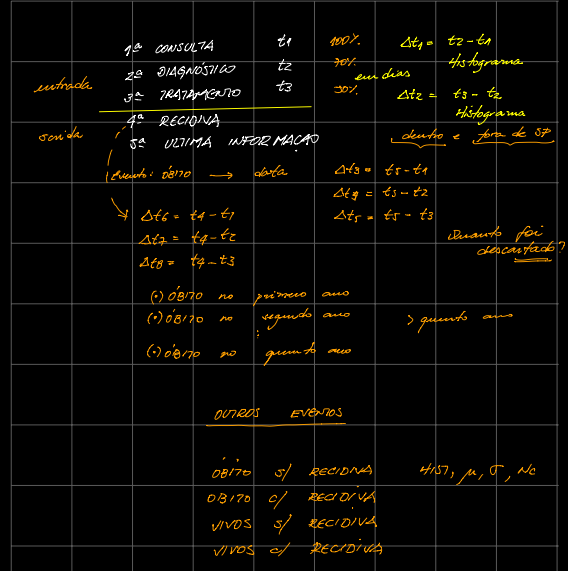

In [ ]:
df = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/colorretal_first_pp.csv')
df.head(2)

(33565, 33)


,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DTCONSULT,DIAGPREV,DTDIAG,EC,ECGRUP,DTTRAT,TRATHOSP,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,DTULTINFO,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,FAIXAETAR,DRS,RRAS,DTRECIDIVA,RECNENHUM,IBGEATEN
0,4,19,2,3538709,9,2004-06-22,2,2004-06-22,IV,IV,2004-07-26 00:00:00,I,0,0,1,1,0,0,0,1,1,2018-02-14 00:00:00,2.0,0,34.0,34.0,2004,10-19,10,14,#NULL!,1,3538709
1,9,19,1,3537107,2,2006-12-20,2,2006-10-17,IIIA,III,2006-12-26 00:00:00,I,0,0,0,1,0,0,0,1,1,2014-04-22 00:00:00,3.0,64,6.0,70.0,2006,10-19,7,15,#NULL!,1,3509502


In [ ]:
# NULL! to NaN
df.loc[df.DTRECIDIVA == '#NULL!', 'DTRECIDIVA'] = np.nan
df.loc[df.DTTRAT == '#NULL!', 'DTTRAT'] = np.nan
df.loc[df.DTULTINFO == '#NULL!', 'DTULTINFO'] = np.nan

In [ ]:
# Dates - DTCONSULT, DTDIAG, DTTRAT, DTULTINFO, DTRECIDIVA
lista_datas = ['DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTULTINFO', 'DTRECIDIVA']
df[lista_datas].isna().sum()

DTCONSULT         0
DTDIAG            0
DTTRAT         1644
DTULTINFO         5
DTRECIDIVA    28500
dtype: int64

In [ ]:
df[lista_datas].head(10)

,DTCONSULT,DTDIAG,DTTRAT,DTULTINFO,DTRECIDIVA
0,2004-06-22,2004-06-22,2004-07-26 00:00:00,2018-02-14 00:00:00,NaN
1,2006-12-20,2006-10-17,2006-12-26 00:00:00,2014-04-22 00:00:00,NaN
2,2007-10-05,2007-09-26,2007-10-11 00:00:00,2020-09-11 00:00:00,NaN
3,2015-06-09,2015-06-10,NaN,2015-07-13 00:00:00,NaN
4,2015-02-26,2015-03-20,2015-04-10 00:00:00,2015-08-02 00:00:00,NaN
5,2017-06-22,2017-06-01,2017-08-01 00:00:00,2019-02-14 00:00:00,NaN
6,2021-07-12,2021-06-09,2021-07-12 00:00:00,2021-07-12 00:00:00,NaN
7,2013-08-20,2013-08-20,2013-08-20 00:00:00,2021-02-15 00:00:00,2018-04-18 00:00:00
8,2010-12-28,2010-12-31,2011-01-11 00:00:00,2012-05-05 00:00:00,2012-01-11 00:00:00
9,2010-12-12,2010-12-12,2011-02-17 00:00:00,2011-02-19 00:00:00,NaN


## **Date difference columns**

The differences between the dates of consultation, diagnosis and treatment will be calculated, and then the difference between the date of recurrence and last information and the first three.

This process will be performed by the function `get_dates_diff`, which drops the empty rows of the `DTTRAT` and `DTULTINFO` columns, converts the date columns to the datetime format and then calculates the difference between the dates in days. 

The idea is presented below.


> See the full function in the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#General).

**Date columns**

* Consultation - $t_1$

* Diagnosis - $t_2$

* Treatment - $t_3$

* Recurrence - $t_4$

* Last information - $t_5$

---

**Difference, in days, between dates:**

$$CONSDIAG = t_2 - t_1$$

$$DIAGTRAT = t_3 - t_2$$

$$TRATCONS = t_3 - t_1$$

**Last information:**

$$ULTICONS = t_5 - t_1$$

$$ULTIDIAG = t_5 - t_2$$

$$ULTITRAT = t_5 - t_3$$

In [ ]:
dates = ['CONSDIAG', 'DIAGTRAT', 'TRATCONS', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT']

New columns with the dates difference

In [ ]:
df = get_dates_diff(df, lista_datas)
print(df.shape)
df[dates].head(3)

(31916, 31)


,CONSDIAG,DIAGTRAT,TRATCONS,ULTICONS,ULTIDIAG,ULTITRAT
0,0,34,34,4985,4985,4951
1,-64,70,6,2680,2744,2674
2,-9,15,6,4725,4734,4719


In [ ]:
df.head(3)

,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,ECGRUP,TRATHOSP,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,FAIXAETAR,DRS,RRAS,RECNENHUM,IBGEATEN,ULTICONS,ULTIDIAG,ULTITRAT
0,4,19,2,3538709,9,2,IV,IV,I,0,0,1,1,0,0,0,1,1,2.0,0,34,34,2004,10-19,10,14,1,3538709,4985,4985,4951
1,9,19,1,3537107,2,2,IIIA,III,I,0,0,0,1,0,0,0,1,1,3.0,-64,6,70,2006,10-19,7,15,1,3509502,2680,2744,2674
2,4,19,1,3516200,9,2,IIB,II,F,0,0,1,1,0,0,0,0,1,2.0,-9,6,15,2007,10-19,8,13,1,3516200,4725,4734,4719


## **Histograms**

In [ ]:
fig = px.histogram(df, x='CONSDIAG', marginal='box',
                   title='Diferença de dias entre diagnóstico e consulta')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df, x='DIAGTRAT', marginal='box',
                   title='Diferença de dias entre tratamento e diagnóstico')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df, x='TRATCONS', marginal='box', 
                   title='Diferença de dias entre tratamento e consulta')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df, x='ULTICONS', marginal='box',
                   title='Diferença de dias entre última informação e consulta')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df, x='ULTIDIAG', marginal='box',
                   title='Diferença de dias entre última informação e diagnóstico')
fig.show(config = {'staticPlot': True})

In [ ]:
fig = px.histogram(df, x='ULTITRAT', marginal='box', 
                   title='Diferença de dias entre última informação e tratamento')
fig.show(config = {'staticPlot': True})

## **Creation of death label**

In this section, labels will be created based on the latest information, one column only if the person died or not (`obito_geral`) and one for death by cancer (`obito_cancer`)
Another three columns will have the information about how many years after the diagnosis the person lived (`vivo_ano1`, `vivo_ano3`, `vivo_ano5`). 

After creating the columns, the datasets will be saved in csv files, one for São Paulo and one for the other states.

> This process will be performed by the `get_labels` function, see the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#General) to see the complete function.

**Death labels**

* Death at any time - obito_geral;

* Death by cancer - obito_cancer;

* Patient is alive after one year - vivo_ano1;

* Patient is alive after three years - vivo_ano3;

* Patient is alive after five years - vivo_ano5.
---

**Last information**

1 - Alive with cancer

2 - Alive, without other specifications

3 - Death by cancer

4 - Death by other causes


In [ ]:
df.head(2)

,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,ECGRUP,TRATHOSP,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,FAIXAETAR,DRS,RRAS,RECNENHUM,IBGEATEN,ULTICONS,ULTIDIAG,ULTITRAT
0,4,19,2,3538709,9,2,IV,IV,I,0,0,1,1,0,0,0,1,1,2.0,0,34,34,2004,10-19,10,14,1,3538709,4985,4985,4951
1,9,19,1,3537107,2,2,IIIA,III,I,0,0,0,1,0,0,0,1,1,3.0,-64,6,70,2006,10-19,7,15,1,3509502,2680,2744,2674


In [ ]:
df.ULTINFO.value_counts()

3.0    13136
2.0    10430
1.0     4589
4.0     3761
Name: ULTINFO, dtype: int64

In [ ]:
df = get_labels(df)
df.shape

(31916, 36)

In [ ]:
columns = ['ULTINFO', 'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano3', 'vivo_ano5']

df[columns].head(2)

,ULTINFO,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5
0,2.0,0,0,1,1,1
1,3.0,1,1,1,1,1


In [ ]:
df[columns][df.obito_geral == 0].head(10)

,ULTINFO,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5
0,2.0,0,0,1,1,1
2,2.0,0,0,1,1,1
5,2.0,0,0,1,0,0
6,1.0,0,0,0,0,0
7,1.0,0,0,1,1,1
21,1.0,0,0,0,0,0
22,1.0,0,0,0,0,0
29,2.0,0,0,1,1,1
31,2.0,0,0,1,1,1
33,2.0,0,0,1,1,1


## **Inputer ESCOLARI**

In [ ]:
cols = ['ESCOLARI', 'IDADE', 'ECGRUP', 'SEXO']
df_esc = df[cols].copy()
df_esc.head(3)

,ESCOLARI,IDADE,ECGRUP,SEXO
0,4,19,IV,2
1,9,19,III,1
2,4,19,II,1


In [ ]:
df_esc.loc[df_esc.ESCOLARI == 9, 'ESCOLARI'] = np.nan
df_esc.loc[df_esc.ECGRUP == 'I', 'ECGRUP'] = 1
df_esc.loc[df_esc.ECGRUP == 'II', 'ECGRUP'] = 2
df_esc.loc[df_esc.ECGRUP == 'III', 'ECGRUP'] = 3
df_esc.loc[df_esc.ECGRUP == 'IV', 'ECGRUP'] = 4
df_esc.ESCOLARI.value_counts(dropna=False)

NaN    9759
2.0    8580
3.0    6041
4.0    4155
5.0    2116
1.0    1265
Name: ESCOLARI, dtype: int64

In [ ]:
from sklearn.impute import KNNImputer

X = df_esc.values
imputer = KNNImputer(n_neighbors=5, weights='distance')
df_esc.ESCOLARI = imputer.fit_transform(X)
df_esc.head(3)

,ESCOLARI,IDADE,ECGRUP,SEXO
0,4.000000,19,4,2
1,3.546918,19,3,1
2,4.000000,19,2,1


In [ ]:
df['ESCOLARI_2'] = df_esc.ESCOLARI.round()
df.ESCOLARI_2.value_counts(dropna=False)

3.0    11666
2.0    11291
4.0     5544
5.0     2122
1.0     1293
Name: ESCOLARI_2, dtype: int64

In [ ]:
df.ESCOLARI.value_counts()

9    9759
2    8580
3    6041
4    4155
5    2116
1    1265
Name: ESCOLARI, dtype: int64

In [ ]:
save_csv(df, '/content/drive/MyDrive/Trabalho/Cancer/Datasets/colorretal_sp_labels.csv')

CSV file saved successfully!


## **Creation of recurrence labels**

In this section, labels will be created based on the recurrence, two columns for people who died, one without recurrence and one with recurrence, and two for people who are alive, also one without recurrence and one with recurrence. 

After creating the columns, the datasets will be saved in csv files, one for São Paulo and one for the other states, now both datasets have 94 columns. 

> This process will be performed by the `get_labels_rec` function, see the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#General) to see the complete function.

**Recurrence labels**

* Death without recurrence - ob_sem_rec;

* Death with recurrence - ob_com_rec;

* Alive without recurrence - vivo_sem_rec;

* Alive with recurrence - vivo_com_rec.

---

**Last information**

1 - Alive with cancer

2 - Alive, without other specifications

3 - Death by cancer

4 - Death by other causes


In [ ]:
# df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')

In [ ]:
# df_SP.head(2)

In [ ]:
# df_SP = get_label_rec(df_SP)

In [ ]:
# columns = ['RECNENHUM', 'obito_geral', 'obito_cancer', 'ob_com_rec', 'ob_sem_rec',
        #    'vivo_com_rec', 'vivo_sem_rec']
# df_SP[columns].head()

In [ ]:
# save_csv(df_SP, '/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')

## **Verificação dos dados criados**

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/colorretal_sp_labels.csv')

(31916, 37)


In [ ]:
df_SP.head(2)

,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,ECGRUP,TRATHOSP,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,FAIXAETAR,DRS,RRAS,RECNENHUM,IBGEATEN,ULTICONS,ULTIDIAG,ULTITRAT,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5,ESCOLARI_2
0,4,19,2,3538709,9,2,IV,IV,I,0,0,1,1,0,0,0,1,1,2.0,0,34,34,2004,10-19,10,14,1,3538709,4985,4985,4951,0,0,1,1,1,4.0
1,9,19,1,3537107,2,2,IIIA,III,I,0,0,0,1,0,0,0,1,1,3.0,-64,6,70,2006,10-19,7,15,1,3509502,2680,2744,2674,1,1,1,1,1,4.0


### **Features das datas**

**Date columns**

* Consultation - $t_1$

* Diagnosis - $t_2$

* Treatment - $t_3$

* Recurrence - $t_4$

* Last information - $t_5$

---

**Difference, in days, between dates:**

$$CONSDIAG = t_2 - t_1$$

$$DIAGTRAT = t_3 - t_2$$

$$TRATCONS = t_3 - t_1$$

**Recurrence:**

$$RECCONS = t_4 - t_1$$

$$RECDIAG = t_4 - t_2$$

$$RECTRAT = t_4 - t_3$$

**Last information:**

$$ULTICONS = t_5 - t_1$$

$$ULTIDIAG = t_5 - t_2$$

$$ULTITRAT = t_5 - t_3$$

**SP**

In [ ]:
# Diagnóstico antes da consulta
df_SP[df_SP.CONSDIAG < 0].shape

(16890, 37)

In [ ]:
# Tratamento antes do diagnóstico
df_SP[df_SP.DIAGTRAT < 0].shape

(0, 37)

In [ ]:
# Tratamento antes da consulta
df_SP[df_SP.TRATCONS < 0].shape

(0, 37)

In [ ]:
# Última informação antes da consulta
df_SP[df_SP.ULTICONS < 0].shape

(0, 37)

In [ ]:
# Última informação antes do diagnóstico
df_SP[df_SP.ULTIDIAG < 0].shape

(0, 37)

In [ ]:
df_SP[df_SP.ULTIDIAG > 365].shape

(23200, 37)

In [ ]:
df_SP[df_SP.ULTIDIAG > 365*3].shape

(13638, 37)

In [ ]:
df_SP[df_SP.ULTIDIAG > 365*5].shape

(8522, 37)

In [ ]:
# Última informação antes do tratamento
df_SP[df_SP.ULTITRAT < 0].shape

(5, 37)

### **Labels óbito**
* Óbito em qualquer momento - ob

* Patient is alive after one year - vivo_ano1;

* Patient is alive after three years - vivo_ano3;

* Patient is alive after five years - vivo_ano5;

**SP**

In [ ]:
df_SP.obito_geral.value_counts()

1    16897
0    15019
Name: obito_geral, dtype: int64

In [ ]:
df_SP.obito_cancer.value_counts()

0    18780
1    13136
Name: obito_cancer, dtype: int64

In [ ]:
df_SP.vivo_ano1.value_counts()

1    23200
0     8716
Name: vivo_ano1, dtype: int64

In [ ]:
df_SP.vivo_ano3.value_counts()

0    18278
1    13638
Name: vivo_ano3, dtype: int64

In [ ]:
df_SP.vivo_ano5.value_counts()

0    23394
1     8522
Name: vivo_ano5, dtype: int64

In [ ]:
df_SP[(df_SP.obito_geral == 0) & (df_SP.vivo_ano1 == 0) & (df_SP.vivo_ano3 == 0) & (df_SP.vivo_ano5 == 0)].shape

(2246, 37)

In [ ]:
df_SP[(df_SP.obito_geral == 0) & (df_SP.vivo_ano1 == 1) & (df_SP.vivo_ano3 == 0) & (df_SP.vivo_ano5 == 0)].shape

(3439, 37)

In [ ]:
df_SP[(df_SP.obito_geral == 0) & (df_SP.vivo_ano1 == 1) & (df_SP.vivo_ano3 == 1) & (df_SP.vivo_ano5 == 0)].shape

(2893, 37)

### **Labels recidiva**
* Óbito sem recidiva - ob_sem_rec

* Óbito com recidiva - ob_com_rec

* Vivos sem recidiva - vivo_sem_rec

* Vivos com recidiva - vivo_com_rec
---


**SP**

In [ ]:
# df_SP.ob_sem_rec.value_counts()

In [ ]:
# df_SP.ob_com_rec.value_counts()

In [ ]:
# df_SP.vivo_sem_rec.value_counts()

In [ ]:
# df_SP.vivo_com_rec.value_counts()

# **Informações**

In [ ]:
def percent_surv(df):
    """
    """
    df_aux = df.copy()
    df_aux['meses_trat'] = (df_aux['ULTITRAT']/30).round()
    df_aux = (df_aux.groupby(by=['meses_trat'])['obito_geral'].sum()/df_aux.shape[0]).reset_index()

    soma = 1
    val = df_aux['obito_geral'].values.copy()
    for i in range(df_aux.shape[0]):
        soma -= df_aux.obito_geral[i]
        val[i] = soma
        
    df_aux['perc'] = val

    return df_aux

In [ ]:
%%capture

!pip install pandas-profiling -U

from pandas_profiling import ProfileReport

In [ ]:
profile = ProfileReport(df.copy())
profile.to_notebook_iframe()

In [ ]:
df = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/colorretal_sp_labels.csv')

(31916, 37)


In [ ]:
df.head(3)

,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,ECGRUP,TRATHOSP,NENHUM,...,IBGEATEN,ULTICONS,ULTIDIAG,ULTITRAT,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5,ESCOLARI_2
0,4,19,2,3538709,9,2,IV,IV,I,0,...,3538709,4985,4985,4951,0,0,1,1,1,4.0
1,9,19,1,3537107,2,2,IIIA,III,I,0,...,3509502,2680,2744,2674,1,1,1,1,1,4.0
2,4,19,1,3516200,9,2,IIB,II,F,0,...,3516200,4725,4734,4719,0,0,1,1,1,4.0


In [ ]:
df.obito_geral.value_counts(True)

1    0.529421
0    0.470579
Name: obito_geral, dtype: float64

In [ ]:
df_surv = percent_surv(df)
df_surv.head(3)

,meses_trat,obito_geral,perc
0,-2.0,0.000000,1.000000
1,-1.0,0.000000,1.000000
2,0.0,0.030706,0.969294


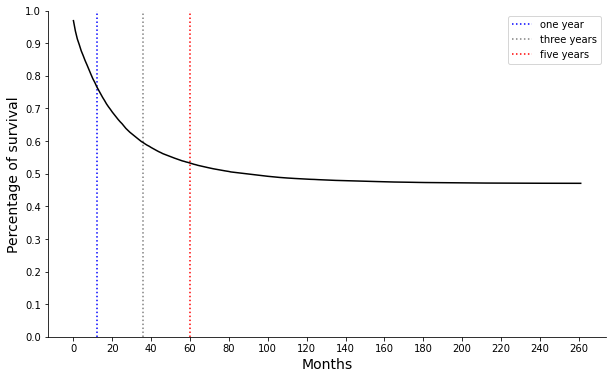

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_surv.meses_trat[2:], df_surv.perc[2:], color='k')
plt.xlabel('Months', size=14)
plt.xticks(np.linspace(0, 260, 14))
plt.yticks(np.linspace(0, 1, 11))
plt.ylabel('Percentage of survival', size=14)
# plt.title('Time (in days) between consultation and diagnosis for each year', size=16)
plt.ylim([0, 1.])
plt.vlines(12, 0, 1, colors='b', label='one year', linestyle='dotted')
plt.vlines(36, 0, 1, colors='gray', label='three years', linestyle='dotted')
plt.vlines(60, 0, 1, colors='r', label='five years', linestyle='dotted')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.show()

In [ ]:
fig = go.Figure(data=go.Scatter(x=df_surv.meses_trat[2:], y=df_surv.perc[2:]))
fig.show()

In [ ]:
# 12 = 0.7666
# 24 = 0.6595
# 36 = 0.5950

In [ ]:
df.ECGRUP.unique()

array(['IV', 'III', 'II', 'I'], dtype=object)

In [ ]:
df_1 = df.query("ECGRUP == 'I'")
df_surv1 = percent_surv(df_1)
df_surv1.head(3)

,meses_trat,obito_geral,perc
0,0.0,0.016914,0.983086
1,1.0,0.014052,0.969035
2,2.0,0.009888,0.959147


In [ ]:
df_2 = df.query("ECGRUP == 'II'")
df_surv2 = percent_surv(df_2)
df_surv2.head(3)

,meses_trat,obito_geral,perc
0,0.0,0.024942,0.975058
1,1.0,0.019534,0.955524
2,2.0,0.012140,0.943384


In [ ]:
df_3 = df.query("ECGRUP == 'III'")
df_surv3 = percent_surv(df_3)
df_surv3 = df_surv3.query("meses_trat >= 0")
df_surv3.head(3)

,meses_trat,obito_geral,perc
2,0.0,0.026163,0.973837
3,1.0,0.023404,0.950433
4,2.0,0.015222,0.935211


In [ ]:
df_4 = df.query("ECGRUP == 'IV'")
df_surv4 = percent_surv(df_4)
df_surv4 = df_surv4.query("meses_trat >= 0")
df_surv4.head(3)

,meses_trat,obito_geral,perc
1,0.0,0.048700,0.951300
2,1.0,0.063169,0.888131
3,2.0,0.055288,0.832843


In [ ]:
# 'solid', 'dashed', 'dashdot', 'dotted'

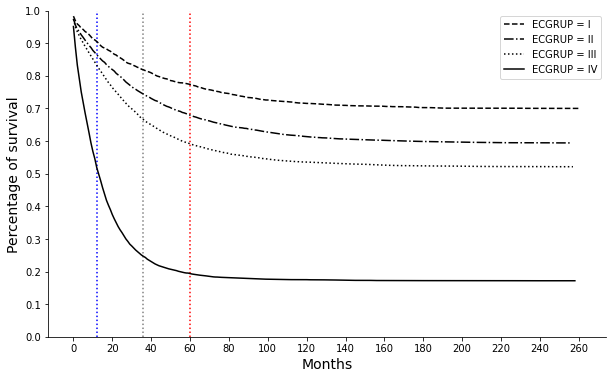

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_surv1.meses_trat, df_surv1.perc, color='k', label='ECGRUP = I', linestyle='dashed')
plt.plot(df_surv2.meses_trat, df_surv2.perc, color='k', label='ECGRUP = II', linestyle='dashdot')
plt.plot(df_surv3.meses_trat, df_surv3.perc, color='k', label='ECGRUP = III', linestyle='dotted')
plt.plot(df_surv4.meses_trat, df_surv4.perc, color='k', label='ECGRUP = IV')

plt.xlabel('Months', size=14)
plt.xticks(np.linspace(0, 260, 14))
plt.yticks(np.linspace(0, 1, 11))
plt.ylabel('Percentage of survival', size=14)
# plt.title('Time (in days) between consultation and diagnosis for each year', size=16)

plt.vlines(12, 0, 1, colors='b', #label='one year', 
           linestyle='dotted')
plt.vlines(36, 0, 1, colors='gray', #label='three years', 
           linestyle='dotted')
plt.vlines(60, 0, 1, colors='r', #label='five years', 
           linestyle='dotted')

plt.ylim([0, 1.])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.show()

In [ ]:
x_num, _, _, _ = train_preprocessing(df)

In [ ]:
df_num = pd.DataFrame(x_num, columns=df.columns)
df_num.head(2)

,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,ECGRUP,TRATHOSP,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,FAIXAETAR,DRS,RRAS,RECNENHUM,IBGEATEN,ULTICONS,ULTIDIAG,ULTITRAT,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5,ESCOLARI_2
0,-0.253018,-3.299481,1.035665,0.210216,1.367283,0.848573,1.061659,1.280887,1.854576,-0.055498,-1.582458,1.606373,0.646176,-0.080993,-0.005598,-0.034526,3.54701,0.020186,-0.572564,0.134859,-0.137852,-0.258924,-1.386569,-3.852478,0.699649,0.990404,0.377504,0.181498,2.584255,2.583427,2.600269,-1.060680,-0.836342,0.612935,1.157681,1.656843,1.164145
1,1.435320,-3.299481,-0.965563,0.117521,-0.692205,0.848573,0.227114,0.262990,1.854576,-0.055498,-1.582458,-0.622520,0.646176,-0.080993,-0.005598,-0.034526,3.54701,0.020186,0.564654,-0.398088,-0.400906,0.043048,-1.017268,-3.852478,0.152667,1.214091,0.377504,-1.412587,0.949362,0.987343,0.981746,0.942792,1.195683,0.612935,1.157681,1.656843,1.164145


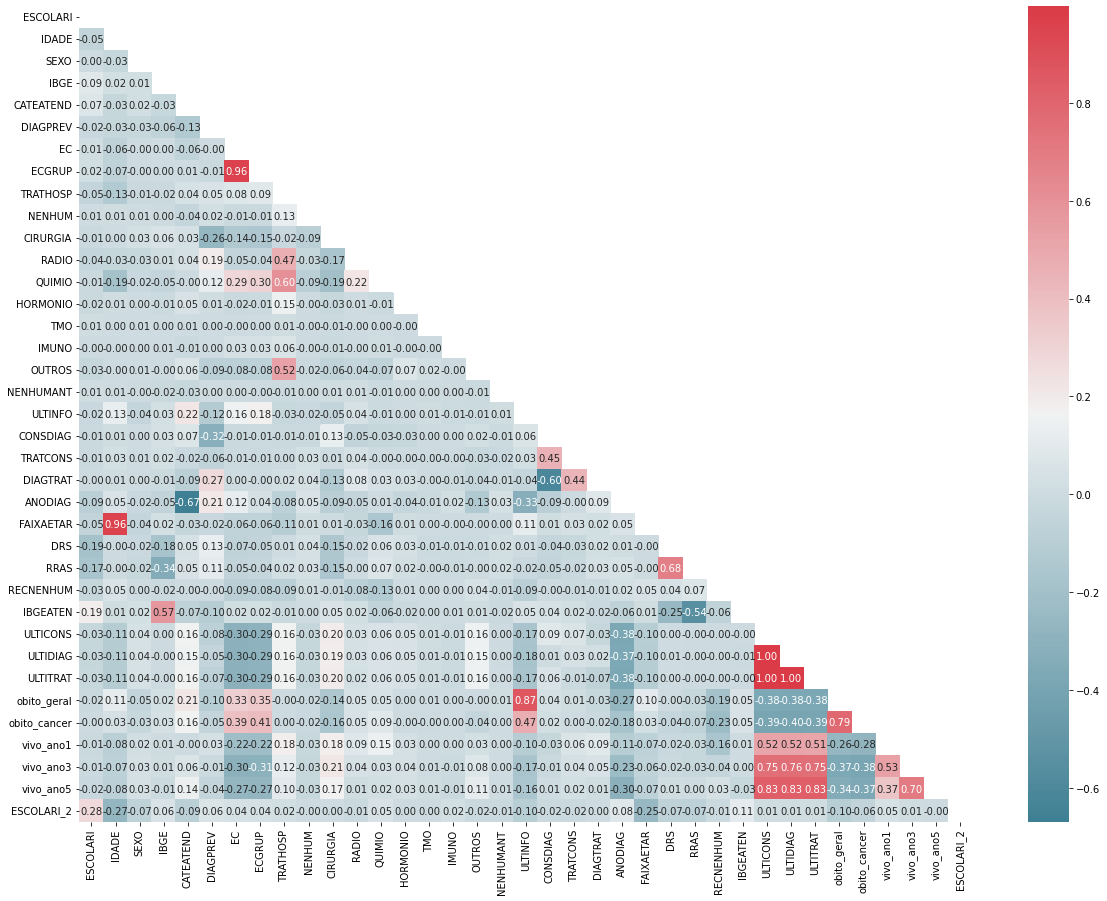

In [ ]:
corr_matrix = df_num.corr()
fig, ax = plt.subplots(figsize = (20, 15))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
mask = np.triu(np.ones_like(corr_matrix, dtype = np.bool))
sns.heatmap(corr_matrix, cmap = colormap, mask = mask, annot = True, fmt = '.2f')
fig.show()

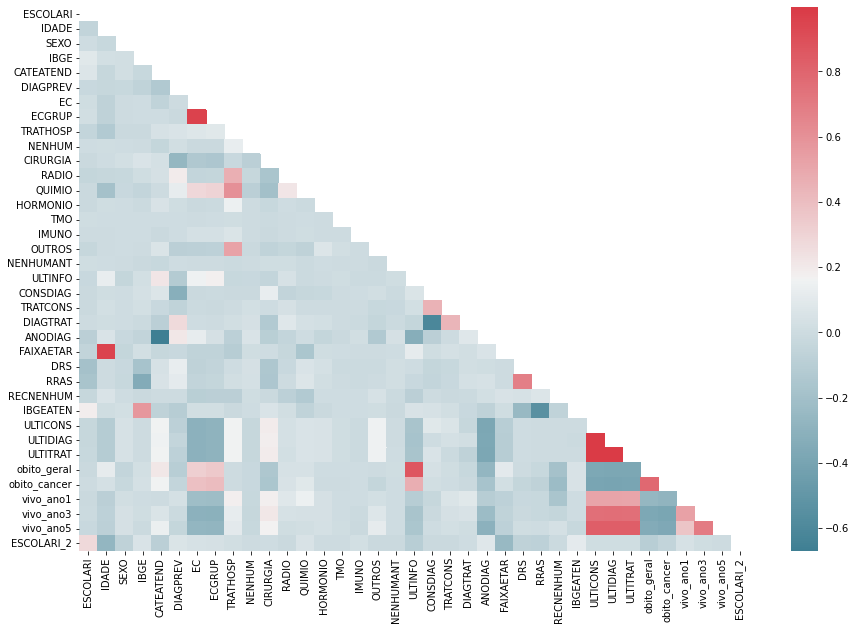

In [ ]:
# corr_matrix = df_num.corr()
fig, ax = plt.subplots(figsize = (15, 10))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
mask = np.triu(np.ones_like(corr_matrix, dtype = np.bool))
sns.heatmap(corr_matrix, cmap = colormap, mask = mask)# annot = True, fmt = '.2f')
fig.show()

In [ ]:
feat = ['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'TRATHOSP', 
        'NENHUM', 'CIRURGIA', 'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO',
        'OUTROS', 'NENHUMANT', 'CONSDIAG', 'TRATCONS', 'DIAGTRAT', 'ANODIAG',
        'DRS', 'RRAS', 'RECNENHUM', 'IBGEATEN', 'ESCOLARI_2']
        
len(feat)

25

In [ ]:
df[feat].head(2)

,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,TRATHOSP,NENHUM,CIRURGIA,RADIO,...,NENHUMANT,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,DRS,RRAS,RECNENHUM,IBGEATEN,ESCOLARI_2
0,19,2,3538709,9,2,IV,I,0,0,1,...,1,0,34,34,2004,10,14,1,3538709,4.0
1,19,1,3537107,2,2,IIIA,I,0,0,0,...,1,-64,6,70,2006,7,15,1,3509502,4.0


In [ ]:
x, _, _, _ = train_preprocessing(df[feat])

In [ ]:
x.shape

(31916, 25)

In [ ]:
%%capture

!pip install scipy -U

In [ ]:
# 'obito_cancer', 'obito_geral', 'vivo_ano1', 'vivo_ano3', 'vivo_ano5'

In [ ]:
for col in range(0, 25):
    chisqt = pd.crosstab(x[:, col], df['vivo_ano5'], margins=True)
    value = []

    for i in range(chisqt.shape[0] - 1):
        value.append(chisqt.iloc[i].values)

    print(f'{df[feat].columns[col]}: {chi2_contingency(np.array(value))[1]}')

IDADE: 2.2084145395261123e-12
SEXO: 5.773044601026372e-09
IBGE: 0.9999856563460066
CATEATEND: 4.483250431537308e-139
DIAGPREV: 8.618851808593847e-14
EC: 0.0
TRATHOSP: 1.415718972741552e-264
NENHUM: 2.4053708687648836e-05
CIRURGIA: 5.786855108343045e-193
RADIO: 0.21852737605994846
QUIMIO: 0.0021669555617680266
HORMONIO: 1.771619677922084e-07
TMO: 0.25344507845662423
IMUNO: 0.03213987176680457
OUTROS: 3.844960030132012e-92
NENHUMANT: 0.6534409358672058
CONSDIAG: 1.0
TRATCONS: 1.0
DIAGTRAT: 1.0
ANODIAG: 0.0
DRS: 4.2603479072531886e-39
RRAS: 3.599866700960967e-42
RECNENHUM: 3.4460786722209914e-06
IBGEATEN: 4.5247019043670845e-119
ESCOLARI_2: 0.9939283028739647


In [ ]:
# from scipy.stats import chi2_contingency

# chisqt = pd.crosstab(df.SEXO, df['vivo_ano5'], margins=True)

# value = np.array([chisqt.iloc[0][0:5].values,
#                   chisqt.iloc[1][0:5].values])

# print(chi2_contingency(value)[0:3])

In [ ]:
def variables_preprocessing2(df, dates_list):
    """Do some preprocessing on the DataFrame like strings splits, fill NaN values,
        replace values and drop some columns.

    :param df pd.DataFrame: DataFrame to be preprocessed.

    :return: DataFrame after be preprocessed and get some columns removed
    :rtype: pd.DataFrame
    """

    df_aux = df.copy()
    no_info = '**Sem informação**'

    # DRS
    DRS_expand = df_aux.DRS.str.split(' ', expand=True)
    df_aux['DRS'] = DRS_expand[1]
    df_aux.DRS.fillna('0', inplace=True)

    df_aux.dropna(subset=['DTTRAT', 'DTULTINFO'], inplace=True)
    
    for c in dates_list:
        if c in ['DTTRAT', 'DTULTINFO', 'DTRECIDIVA']: # Has a different date format 
            fmt = '%Y-%m-%d %H:%M:%S'
        else:
            fmt = '%Y-%m-%d'
        df_aux[c] = pd.to_datetime(df_aux[c], format=fmt)
        
    df_aux['CONSDIAG'] = (df_aux.DTDIAG - df_aux.DTCONSULT).dt.days
    df_aux['DIAGTRAT'] = (df_aux.DTTRAT - df_aux.DTDIAG).dt.days
    df_aux['TRATCONS'] = (df_aux.DTTRAT - df_aux.DTCONSULT).dt.days

    df_aux['ULTICONS'] = (df_aux.DTULTINFO - df_aux.DTCONSULT).dt.days
    df_aux['ULTIDIAG'] = (df_aux.DTULTINFO - df_aux.DTDIAG).dt.days
    df_aux['ULTITRAT'] = (df_aux.DTULTINFO - df_aux.DTTRAT).dt.days

    df_aux['obito_geral'] = 0
    df_aux['obito_cancer'] = 0

    df_aux['vivo_ano1'] = 0
    df_aux['vivo_ano3'] = 0
    df_aux['vivo_ano5'] = 0 
    
    df_aux.loc[df_aux.ULTINFO > 2, 'obito_geral'] = 1

    df_aux.loc[df_aux.ULTINFO == 3, 'obito_cancer'] = 1

    df_aux.loc[df_aux.ULTIDIAG > 365, 'vivo_ano1'] = 1
    df_aux.loc[df_aux.ULTIDIAG > 3*365, 'vivo_ano3'] = 1
    df_aux.loc[df_aux.ULTIDIAG > 5*365, 'vivo_ano5'] = 1

    col = df_aux.columns
    drop_cols = ['REC04', 'META01', 'META02', 'META03', 'META04', 'REC01', 
                 'REC02', 'REC03', 'DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTULTINFO', 
                 'DTRECIDIVA', 'DESCTOPO', 'DESCMORFO', 'CIDADE']

    col = col.drop(drop_cols)

    return df_aux[col]

In [ ]:
path = '/content/drive/MyDrive/Trabalho/Cancer/Datasets/ANALITICO_Colorretal_lucas.csv'

df_total = read_csv(path, drop_id=True)

# #NULL! to NaN
df_total.loc[df_total.DTRECIDIVA == '#NULL!', 'DTRECIDIVA'] = np.nan
df_total.loc[df_total.DTULTINFO == '#NULL!', 'DTULTINFO'] = np.nan
df_total.loc[df_total.DTTRAT == '#NULL!', 'DTTRAT'] = np.nan

df_limpo = variables_preprocessing2(df_total, ['DTCONSULT', 'DTDIAG', 'DTTRAT', 'DTULTINFO', 'DTRECIDIVA'])
df_limpo.head(2)

(68013, 68)


,ESCOLARI,IDADE,SEXO,UFNASC,UFRESID,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,MORFO,comportamento,EC,ECGRUP,T,N,M,NAOTRAT,TRATAMENTO,TRATHOSP,TRATFAPOS,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,NENHUMAPOS,CIRURAPOS,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,TMOAPOS,IMUNOAPOS,OUTROAPOS,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,FAIXAETAR,DRS,RRAS,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,IBGEATEN,HABILIT,ULTICONS,ULTIDIAG,ULTITRAT,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5
0,3,19,2,SP,MG,3100104,2,1,C189,C18,81403,3,II,II,3,0,0,8,I,I,J,0,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,2.0,8,8,0,2000,10-19,0,99,1,0,0,0,3550308,CACON,2534,2526,2526,0,0,1,1,1
1,4,19,2,SP,SP,3539301,9,2,C189,C18,82113,3,III,III,2,1,0,8,A,A,J,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,3.0,0,52,52,2001,10-19,10,14,0,1,0,0,3525300,CACON,1328,1328,1276,1,1,1,1,0


In [ ]:
from sklearn.decomposition import PCA

x_tot, _, _ = train_preprocessing(df_limpo)

pca = PCA()
principalComponents = pca.fit_transform(x_tot)

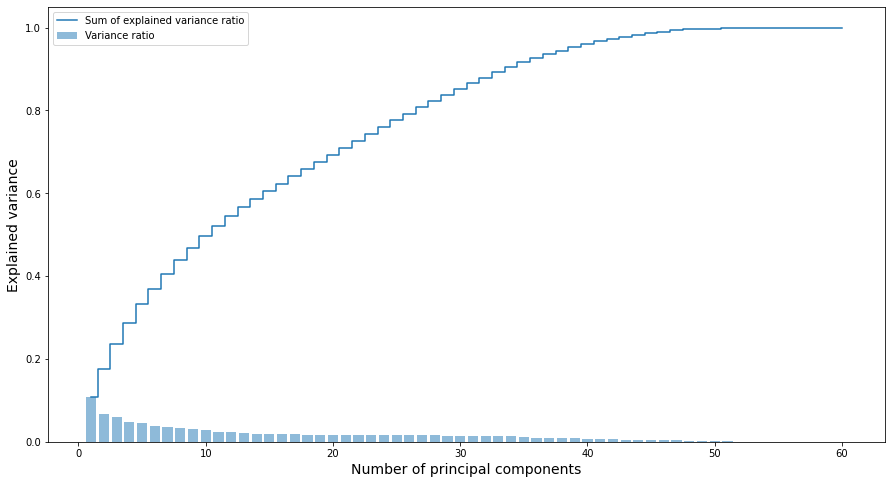

In [ ]:
plt.figure(figsize=(15, 8))

plt.bar(np.linspace(1, x_tot.shape[1], x_tot.shape[1]), 
        pca.explained_variance_ratio_, alpha=0.5, align='center', 
        label='Variance ratio')
plt.step(np.linspace(1, x_tot.shape[1], x_tot.shape[1]), 
         np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

In [ ]:
drop_cols = ['UFRESID', 'UFNASC', 'TMOAPOS']

df_ret1 = df_limpo.drop(columns=drop_cols)
df_ret1.head(2)

,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,TOPO,TOPOGRUP,MORFO,comportamento,EC,ECGRUP,T,N,M,NAOTRAT,TRATAMENTO,TRATHOSP,TRATFAPOS,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,NENHUMAPOS,CIRURAPOS,RADIOAPOS,QUIMIOAPOS,HORMOAPOS,IMUNOAPOS,OUTROAPOS,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,FAIXAETAR,DRS,RRAS,RECNENHUM,RECLOCAL,RECREGIO,RECDIST,IBGEATEN,HABILIT,ULTICONS,ULTIDIAG,ULTITRAT,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5
0,3,19,2,3100104,2,1,C189,C18,81403,3,II,II,3,0,0,8,I,I,J,0,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,2.0,8,8,0,2000,10-19,0,99,1,0,0,0,3550308,CACON,2534,2526,2526,0,0,1,1,1
1,4,19,2,3539301,9,2,C189,C18,82113,3,III,III,2,1,0,8,A,A,J,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,3.0,0,52,52,2001,10-19,10,14,0,1,0,0,3525300,CACON,1328,1328,1276,1,1,1,1,0


In [ ]:
x_ret1, _, _ = train_preprocessing(df_ret1)

# pca = PCA()
principalComponents = pca.fit_transform(x_ret1)

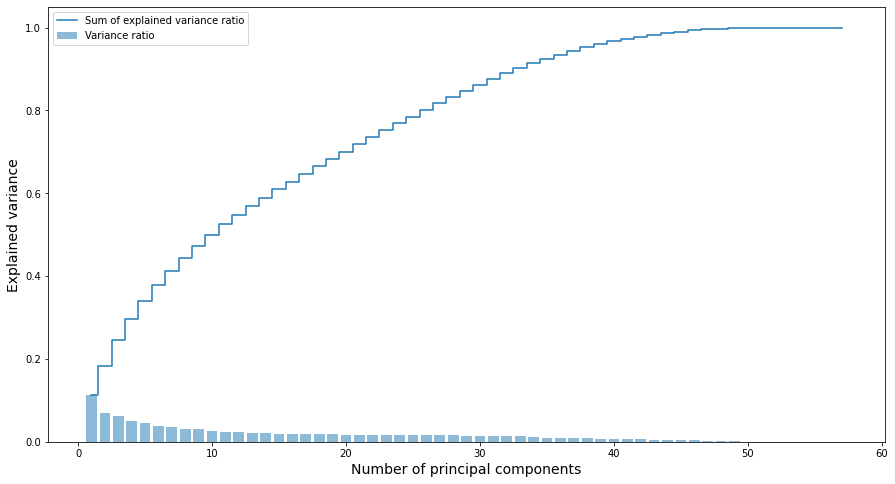

In [ ]:
plt.figure(figsize=(15, 8))

plt.bar(np.linspace(1, x_ret1.shape[1], x_ret1.shape[1]), 
        pca.explained_variance_ratio_, alpha=0.5, align='center', 
        label='Variance ratio')
plt.step(np.linspace(1, x_ret1.shape[1], x_ret1.shape[1]), 
         np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()

In [ ]:
drop = ['TOPO', 'TOPOGRUP', 'T', 'N', 'M', 'NAOTRAT', 'TRATAMENTO', 'TRATFAPOS',
        'NENHUMAPOS', 'CIRURAPOS', 'RADIOAPOS', 'QUIMIOAPOS', 'HORMOAPOS', 
        'IMUNOAPOS', 'OUTROAPOS', 'RECLOCAL', 'RECREGIO', 'RECDIST', 'HABILIT']

df_ret2 = df_ret1.drop(columns=drop)
df_ret2.head(2)

,ESCOLARI,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,MORFO,comportamento,EC,ECGRUP,TRATHOSP,NENHUM,CIRURGIA,RADIO,QUIMIO,HORMONIO,TMO,IMUNO,OUTROS,NENHUMANT,ULTINFO,CONSDIAG,TRATCONS,DIAGTRAT,ANODIAG,FAIXAETAR,DRS,RRAS,RECNENHUM,IBGEATEN,ULTICONS,ULTIDIAG,ULTITRAT,obito_geral,obito_cancer,vivo_ano1,vivo_ano3,vivo_ano5
0,3,19,2,3100104,2,1,81403,3,II,II,I,0,1,1,1,0,0,0,1,1,2.0,8,8,0,2000,10-19,0,99,1,3550308,2534,2526,2526,0,0,1,1,1
1,4,19,2,3539301,9,2,82113,3,III,III,A,0,1,0,0,0,0,0,0,1,3.0,0,52,52,2001,10-19,10,14,0,3525300,1328,1328,1276,1,1,1,1,0


In [ ]:
x_ret2, _, _ = train_preprocessing(df_ret2)

# pca = PCA()
principalComponents = pca.fit_transform(x_ret2)

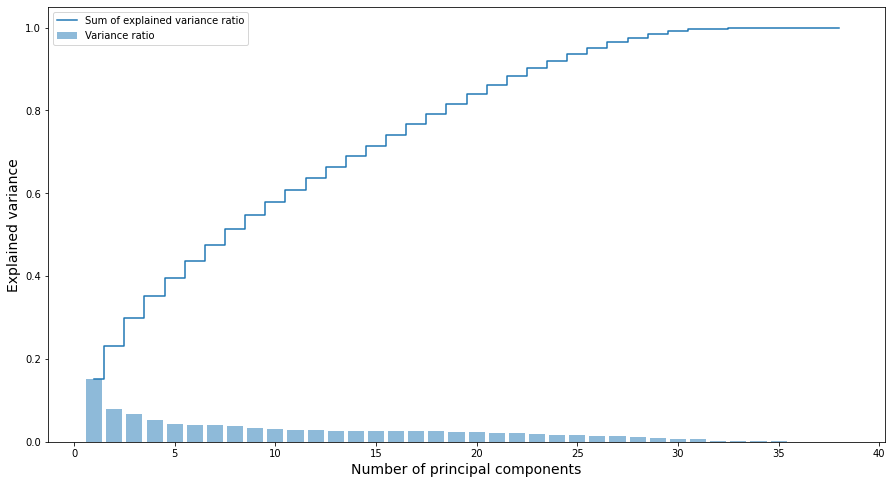

In [ ]:
plt.figure(figsize=(15, 8))

plt.bar(np.linspace(1, x_ret2.shape[1], x_ret2.shape[1]), 
        pca.explained_variance_ratio_, alpha=0.5, align='center', 
        label='Variance ratio')
plt.step(np.linspace(1, x_ret2.shape[1], x_ret2.shape[1]), 
         np.cumsum(pca.explained_variance_ratio_), where='mid',
         label='Sum of explained variance ratio')

plt.ylabel('Explained variance', size=14)
plt.xlabel('Number of principal components', size=14)
plt.legend()

plt.show()